<a href="https://colab.research.google.com/github/ehas1/Statistical-Bias-in-ML/blob/main/XGBoost_Cross_Validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import shap
shap.initjs()
! pip install lime



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=835beba32659c4fb40f53748eec8734638a490fa0c94926d13c0e9718c110aee
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [3]:
df_filtered = pd.read_csv('cox-violent-parsed_filt.csv')



In [4]:
X = df_filtered[["sex", 'age', 'race', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count', 'c_charge_degree']]
Y = df_filtered['is_recid']

categorical_features = ['sex', 'race', 'c_charge_degree']
numerical_features = ['age', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count']

X_encoded = pd.get_dummies(X, columns=categorical_features)

# XGBoost


Loading and preprocessing data...


/tmp/ipython-input-5-1205415753.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['c_charge_degree'] = X['c_charge_degree'].fillna('Unknown')
/tmp/ipython-input-5-1205415753.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['c_charge_degree'] = X['c_charge_degree'].apply(categorize_charge_degree)



Training XGBoost model...
[0]	train-logloss:0.68916	train-error:0.47935	train-auc:0.63924	eval-logloss:0.68954	eval-error:0.48800	eval-auc:0.65158
[100]	train-logloss:0.59679	train-error:0.32402	train-auc:0.74331	eval-logloss:0.60045	eval-error:0.31943	eval-auc:0.74129
[200]	train-logloss:0.58520	train-error:0.31280	train-auc:0.75571	eval-logloss:0.59450	eval-error:0.31543	eval-auc:0.74714
[300]	train-logloss:0.57577	train-error:0.30252	train-auc:0.76602	eval-logloss:0.59006	eval-error:0.31457	eval-auc:0.75156
[400]	train-logloss:0.56763	train-error:0.29680	train-auc:0.77439	eval-logloss:0.58726	eval-error:0.30971	eval-auc:0.75464
[499]	train-logloss:0.56097	train-error:0.29158	train-auc:0.78122	eval-logloss:0.58450	eval-error:0.30914	eval-auc:0.75761

Model Accuracy: 0.6909

Prediction Distribution:
Min probability: 0.0248
Max probability: 0.9849
Mean probability: 0.4736
Std probability: 0.2088

Feature Importance Scores:
priors_count: 5.2
age: 3.7
sex_Female: 3.1
race_African-Americ

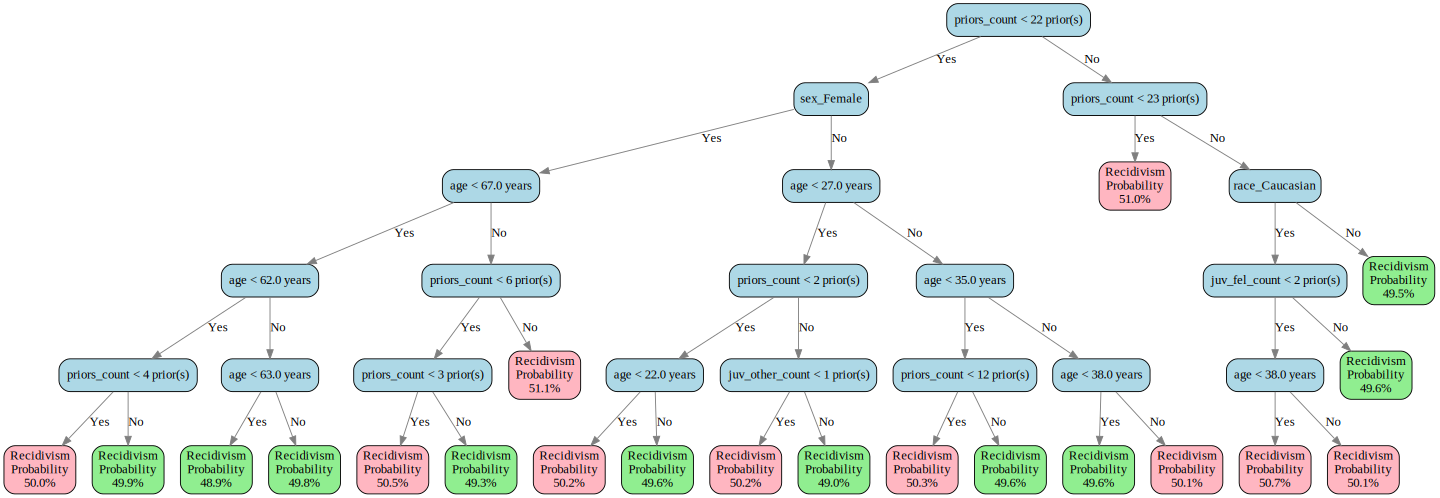

In [5]:
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.calibration import CalibratedClassifierCV
import matplotlib.pyplot as plt
from xgboost import plot_importance
from xgboost.callback import TrainingCallback
import json
from graphviz import Digraph
from IPython.display import display

# Load and preprocess data
print("\nLoading and preprocessing data...")
data = pd.read_csv('cox-violent-parsed_filt.csv')

# Remove cases where is_recid is -1 (unknown/pending)
data = data[data['is_recid'] != -1].copy()

# Select specific features
X = data[["sex", 'age', 'race', 'juv_fel_count', 'juv_misd_count', 'juv_other_count',
          'priors_count', 'c_charge_degree']]
y = data['is_recid']

# Store original value ranges for denormalization
value_ranges = {}
for col in ['age', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count']:
    value_ranges[col] = {
        'min': float(X[col].min()),
        'max': float(X[col].max())
    }

# Save value ranges for visualization
with open('value_ranges.json', 'w') as f:
    json.dump(value_ranges, f)

# Fill missing values
X['c_charge_degree'] = X['c_charge_degree'].fillna('Unknown')

def categorize_charge_degree(x):
    if pd.isna(x) or x == 'Unknown':
        return 'Other'
    if str(x).startswith('F'):
        return 'Felony'
    if str(x).startswith('M'):
        return 'Misdemeanor'
    return 'Other'

X['c_charge_degree'] = X['c_charge_degree'].apply(categorize_charge_degree)

# Define categorical and numerical features
categorical_features = ['sex', 'race', 'c_charge_degree']
numerical_features = ['age', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count']

# One-hot encode categorical features
X_encoded = pd.get_dummies(X, columns=categorical_features)

# Clean up feature names
X_encoded.columns = [col.replace('[', '_').replace(']', '_').replace('<', '_').replace('>', '_')
                    for col in X_encoded.columns]

# Normalize numerical features
for col in numerical_features:
    if col in X_encoded.columns:
        min_val = X_encoded[col].min()
        max_val = X_encoded[col].max()
        if max_val > min_val:
            X_encoded[col] = (X_encoded[col] - min_val) / (max_val - min_val)


# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Train model with better parameters
print("\nTraining XGBoost model...")
params = {
    'objective': 'binary:logistic',
    'eval_metric': ['logloss', 'error', 'auc'],
    'eta': 0.05,  # Lower learning rate
    'max_depth': 5,
    'min_child_weight': 2,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'scale_pos_weight': 1,  # Balance positive and negative weights
    'base_score': np.mean(y_train),  # Set base score to mean of target
    'tree_method': 'hist'
}

# Create DMatrix objects
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=X_encoded.columns.tolist())
dtest = xgb.DMatrix(X_test, label=y_test, feature_names=X_encoded.columns.tolist())
evallist = [(dtrain, 'train'), (dtest, 'eval')]

# Dictionary to store evaluation results
evaluation_results = {'train': {'error': [], 'auc': [], 'logloss': []},
                     'eval': {'error': [], 'auc': [], 'logloss': []}}

class MetricHistory(TrainingCallback):
    def after_iteration(self, model, epoch, evals_log):
        for data_name, metric_dict in evals_log.items():
            for metric_name, metric_values in metric_dict.items():
                evaluation_results[data_name][metric_name].append(metric_values[-1])
        return False

# Train the model
model = xgb.train(
    params,
    dtrain,
    num_boost_round=500,  # Reduced number of rounds
    early_stopping_rounds=50,  # Add early stopping
    evals=evallist,
    verbose_eval=100,
    callbacks=[MetricHistory()]
)

# Save the model
model.save_model('xgboost_model.json')

# Make predictions
y_pred_prob = model.predict(dtest)
y_pred = (y_pred_prob > 0.5).astype(int)

# Calculate metrics
accuracy = (y_pred == y_test).mean()


print(f"\nModel Accuracy: {accuracy:.4f}")


# Print prediction distribution
print("\nPrediction Distribution:")
print(f"Min probability: {y_pred_prob.min():.4f}")
print(f"Max probability: {y_pred_prob.max():.4f}")
print(f"Mean probability: {y_pred_prob.mean():.4f}")
print(f"Std probability: {y_pred_prob.std():.4f}")

# Get feature importance scores
importance_type = 'gain'
scores = model.get_score(importance_type=importance_type)
feature_importance = pd.DataFrame({
    'feature': list(scores.keys()),
    'importance': list(scores.values())
}).sort_values('importance', ascending=False)

print("\nFeature Importance Scores:")
for idx, row in feature_importance.iterrows():
    print(f"{row['feature']}: {row['importance']:.1f}")

# Save feature importance to CSV
feature_importance.to_csv('feature_importance.csv', index=False)

# Create detailed tree visualization
from graphviz import Digraph
import re
import numpy as np

# Get the tree dump in text format
tree = model.get_dump(dump_format='text')[245]

# Create a new directed graph
dot = Digraph(comment='Decision Tree')
dot.attr(rankdir='TB')  # Top to bottom layout

# Parse the tree dump and create nodes
node_pattern = re.compile(r'(\d+):\[([^\]]+)\] yes=(\d+),no=(\d+).*')
leaf_pattern = re.compile(r'(\d+):leaf=([-\d\.]+)')

def format_node_label(text):
    """Format the node label with actual values"""
    for feature in value_ranges.keys():
        if feature in text:
            match = re.search(rf'{feature}<([\d\.]+)', text)
            if match:
                value = float(match.group(1))
                actual_value = value_ranges[feature]['min'] + float(value) * (value_ranges[feature]['max'] - value_ranges[feature]['min'])
                if feature == 'age':
                    return f'{feature} < {actual_value:.1f} years'
                elif feature.endswith('count'):
                    return f'{feature} < {round(actual_value)} prior(s)'
                else:
                    return f'{feature} < {actual_value:.1f}'
    return text

# Set graph style
dot.attr('node', shape='box', style='rounded,filled', fillcolor='lightblue')
dot.attr('edge', color='gray50')
dot.attr(bgcolor='white')

# Process each line of the tree dump
for line in tree.split('\n'):
    # Skip empty lines
    if not line.strip():
        continue

    # Check if it's a leaf node
    leaf_match = leaf_pattern.match(line.strip())
    if leaf_match:
        node_id, leaf_value = leaf_match.groups()
        prob_value = 1 / (1 + np.exp(-float(leaf_value)))
        # Color leaf nodes based on prediction
        color = 'lightpink' if prob_value >= 0.5 else 'lightgreen'
        dot.node(str(node_id), f'Recidivism\nProbability\n{prob_value:.1%}',
                fillcolor=color)
        continue

    # Process split node
    node_match = node_pattern.match(line.strip())
    if node_match:
        node_id, condition, yes_id, no_id = node_match.groups()
        # Format the condition
        formatted_condition = format_node_label(condition)
        dot.node(str(node_id), formatted_condition)
        # Add edges with labels
        dot.edge(str(node_id), str(yes_id), 'Yes')
        dot.edge(str(node_id), str(no_id), 'No')

# Set graph attributes for better visualization
dot.attr(size='20,40')  # Swapped dimensions for vertical layout
dot.attr(fontsize='14')

# Display the graph in the notebook
from IPython.display import display
display(dot)

## 5-Fold Cross Validation (Depth 5)

> Add blockquote




Loading and preprocessing data...


/tmp/ipython-input-20-2495908934.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['c_charge_degree'] = X['c_charge_degree'].fillna('Unknown')
/tmp/ipython-input-20-2495908934.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['c_charge_degree'] = X['c_charge_degree'].apply(categorize_charge_degree)



Starting 5-fold cross-validation...

Training fold 1/5
[0]	train-logloss:0.68923	train-error:0.47714	train-auc:0.63645	eval-logloss:0.68948	eval-error:0.48400	eval-auc:0.64946
[100]	train-logloss:0.59645	train-error:0.32595	train-auc:0.74390	eval-logloss:0.60091	eval-error:0.32400	eval-auc:0.74097
[200]	train-logloss:0.58576	train-error:0.31452	train-auc:0.75456	eval-logloss:0.59560	eval-error:0.31714	eval-auc:0.74573
[300]	train-logloss:0.57715	train-error:0.30759	train-auc:0.76406	eval-logloss:0.59177	eval-error:0.31629	eval-auc:0.74955
[400]	train-logloss:0.56852	train-error:0.29766	train-auc:0.77349	eval-logloss:0.58815	eval-error:0.31571	eval-auc:0.75333
[499]	train-logloss:0.56110	train-error:0.29301	train-auc:0.78116	eval-logloss:0.58533	eval-error:0.31314	eval-auc:0.75597


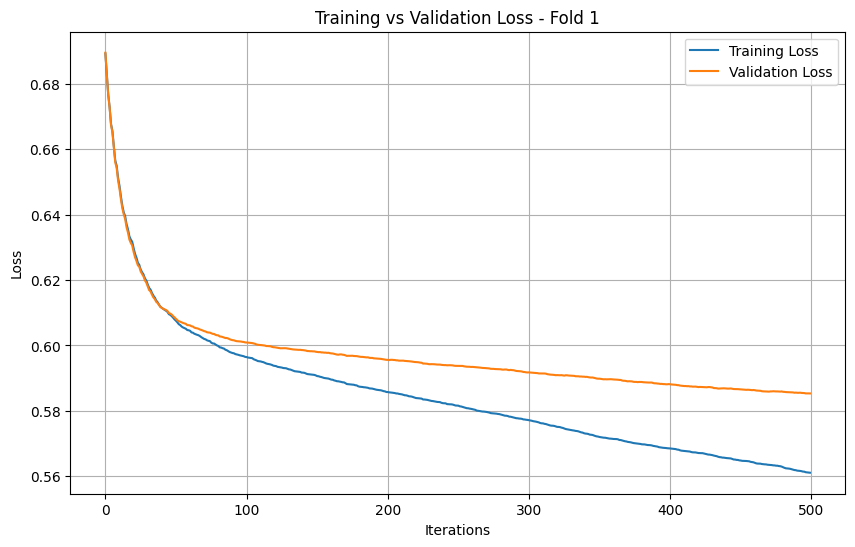

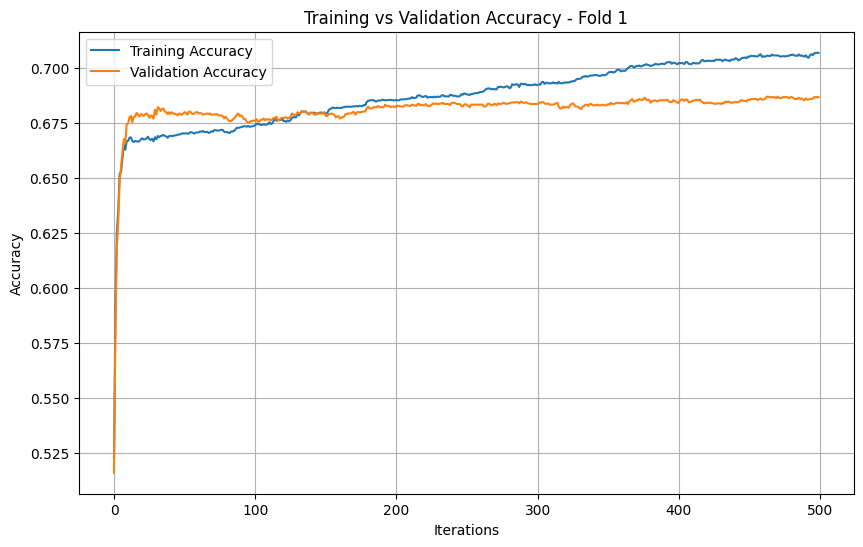

Fold 1 Validation Accuracy: 0.6869

Training fold 2/5
[0]	train-logloss:0.68892	train-error:0.47196	train-auc:0.64194	eval-logloss:0.68966	eval-error:0.47499	eval-auc:0.62113
[100]	train-logloss:0.59264	train-error:0.32028	train-auc:0.74861	eval-logloss:0.61956	eval-error:0.34210	eval-auc:0.71618
[200]	train-logloss:0.58065	train-error:0.31164	train-auc:0.75981	eval-logloss:0.61644	eval-error:0.33724	eval-auc:0.72173
[300]	train-logloss:0.57121	train-error:0.30335	train-auc:0.76986	eval-logloss:0.61448	eval-error:0.33753	eval-auc:0.72592
[400]	train-logloss:0.56307	train-error:0.30128	train-auc:0.77814	eval-logloss:0.61303	eval-error:0.33438	eval-auc:0.72874
[499]	train-logloss:0.55552	train-error:0.29306	train-auc:0.78581	eval-logloss:0.61067	eval-error:0.32867	eval-auc:0.73246


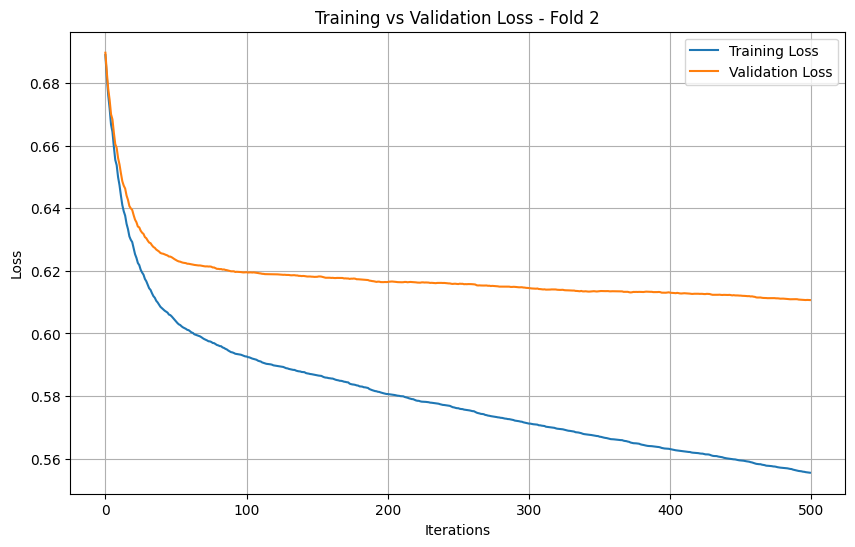

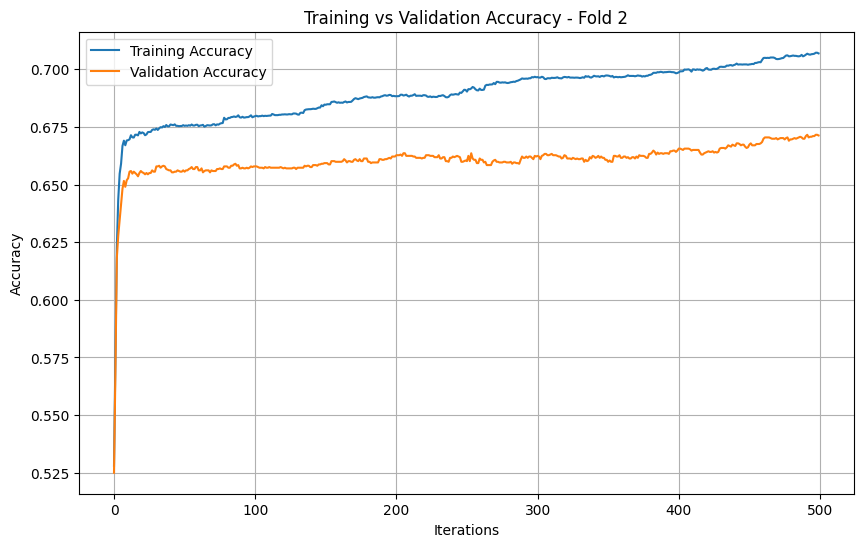

Fold 2 Validation Accuracy: 0.6713

Training fold 3/5
[0]	train-logloss:0.68909	train-error:0.47789	train-auc:0.64238	eval-logloss:0.68963	eval-error:0.48214	eval-auc:0.63360
[100]	train-logloss:0.59482	train-error:0.32178	train-auc:0.74650	eval-logloss:0.60807	eval-error:0.33352	eval-auc:0.72953
[200]	train-logloss:0.58399	train-error:0.31471	train-auc:0.75716	eval-logloss:0.60365	eval-error:0.33667	eval-auc:0.73405
[300]	train-logloss:0.57437	train-error:0.30357	train-auc:0.76750	eval-logloss:0.60057	eval-error:0.33067	eval-auc:0.73793
[400]	train-logloss:0.56600	train-error:0.29635	train-auc:0.77593	eval-logloss:0.59776	eval-error:0.32438	eval-auc:0.74159
[499]	train-logloss:0.55846	train-error:0.28899	train-auc:0.78342	eval-logloss:0.59526	eval-error:0.32095	eval-auc:0.74445


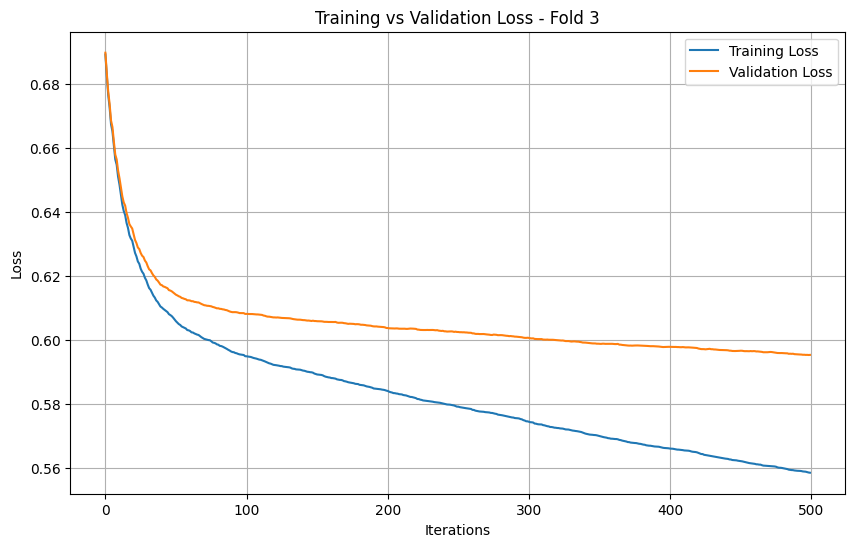

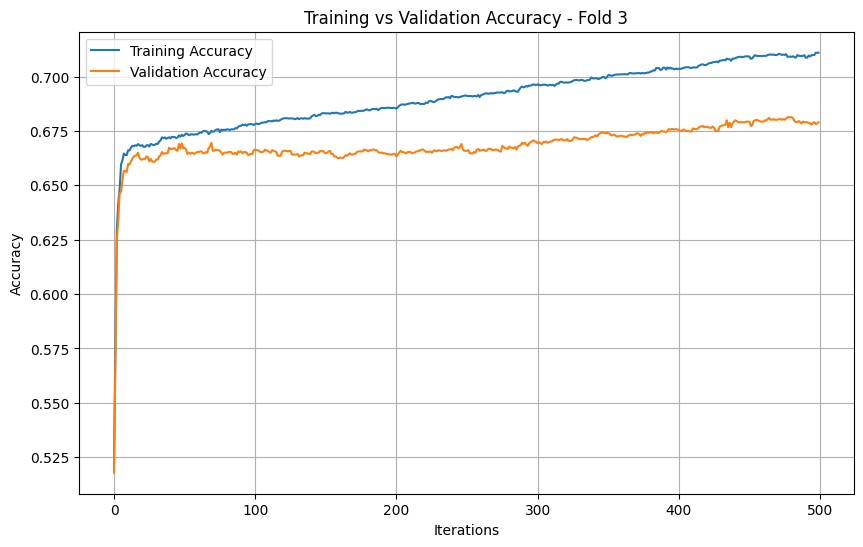

Fold 3 Validation Accuracy: 0.6791

Training fold 4/5
[0]	train-logloss:0.68896	train-error:0.46539	train-auc:0.64199	eval-logloss:0.68996	eval-error:0.47528	eval-auc:0.62635
[100]	train-logloss:0.59505	train-error:0.32078	train-auc:0.74531	eval-logloss:0.60901	eval-error:0.33181	eval-auc:0.72976
[200]	train-logloss:0.58364	train-error:0.31300	train-auc:0.75727	eval-logloss:0.60390	eval-error:0.32924	eval-auc:0.73551
[300]	train-logloss:0.57339	train-error:0.30492	train-auc:0.76789	eval-logloss:0.60015	eval-error:0.32695	eval-auc:0.73977
[400]	train-logloss:0.56548	train-error:0.30035	train-auc:0.77616	eval-logloss:0.59693	eval-error:0.32695	eval-auc:0.74383
[499]	train-logloss:0.55755	train-error:0.29013	train-auc:0.78412	eval-logloss:0.59442	eval-error:0.32009	eval-auc:0.74678


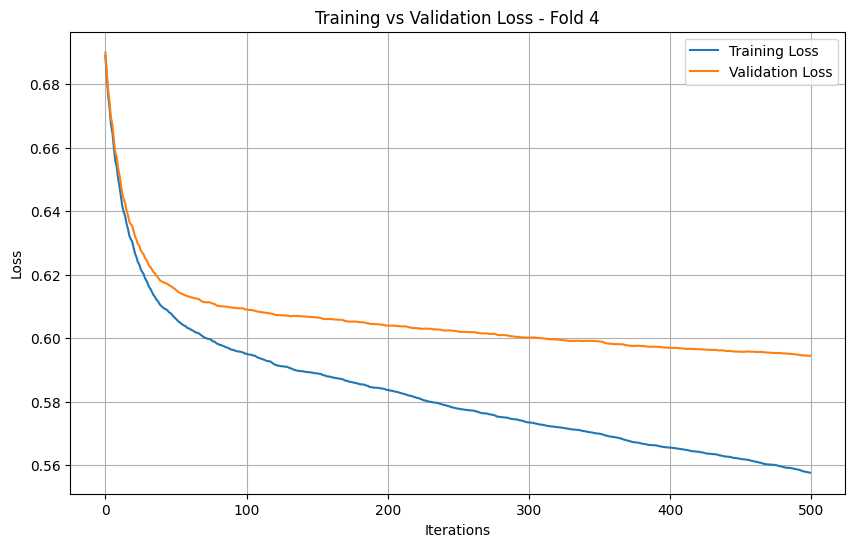

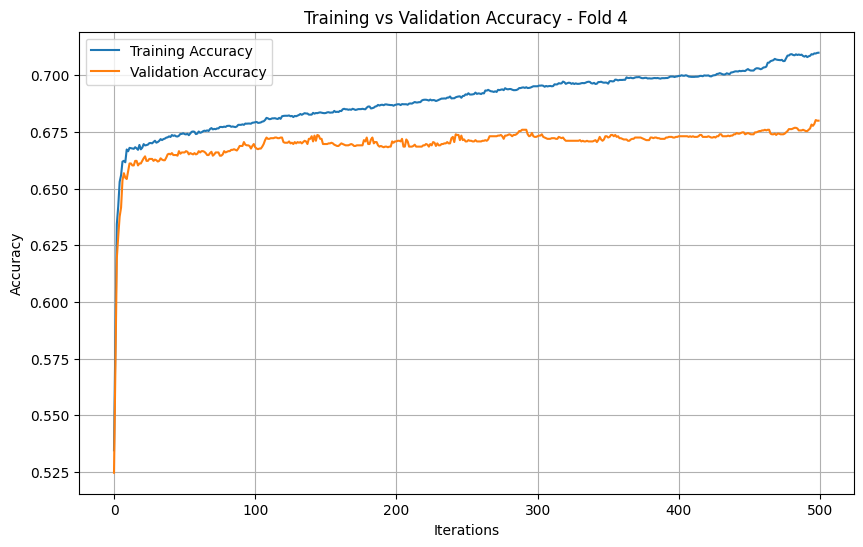

Fold 4 Validation Accuracy: 0.6799

Training fold 5/5
[0]	train-logloss:0.68945	train-error:0.47167	train-auc:0.64122	eval-logloss:0.68793	eval-error:0.45013	eval-auc:0.62770
[100]	train-logloss:0.59452	train-error:0.32107	train-auc:0.74730	eval-logloss:0.60897	eval-error:0.33981	eval-auc:0.72576
[200]	train-logloss:0.58130	train-error:0.31221	train-auc:0.76068	eval-logloss:0.60304	eval-error:0.33495	eval-auc:0.73254
[300]	train-logloss:0.57146	train-error:0.30457	train-auc:0.77139	eval-logloss:0.59897	eval-error:0.33295	eval-auc:0.73751
[400]	train-logloss:0.56341	train-error:0.29628	train-auc:0.77975	eval-logloss:0.59597	eval-error:0.32838	eval-auc:0.74102
[499]	train-logloss:0.55667	train-error:0.29085	train-auc:0.78644	eval-logloss:0.59342	eval-error:0.32123	eval-auc:0.74405


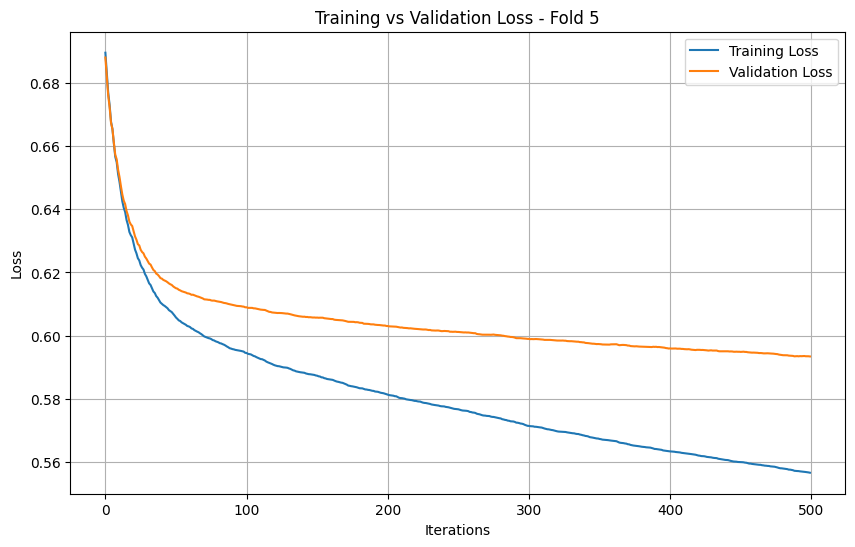

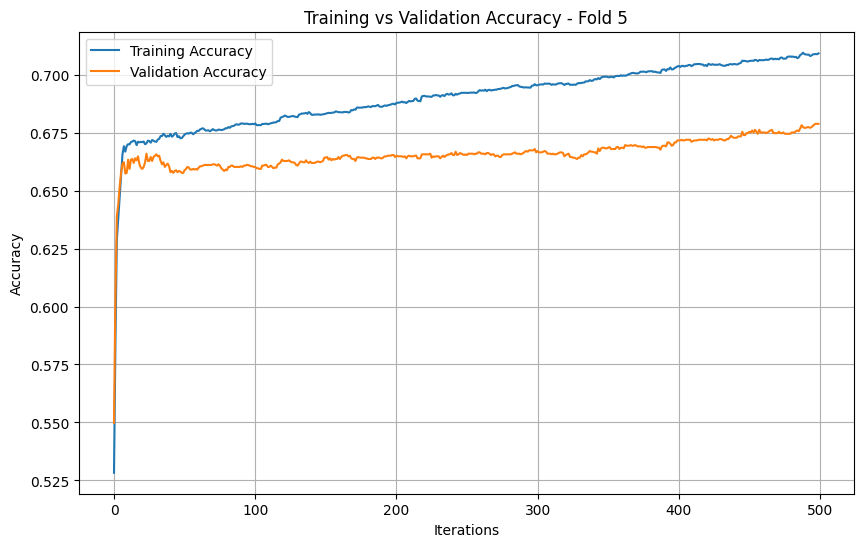

Fold 5 Validation Accuracy: 0.6788

Cross-validation Results:
Mean Accuracy: 0.6792 (+/- 0.0049)


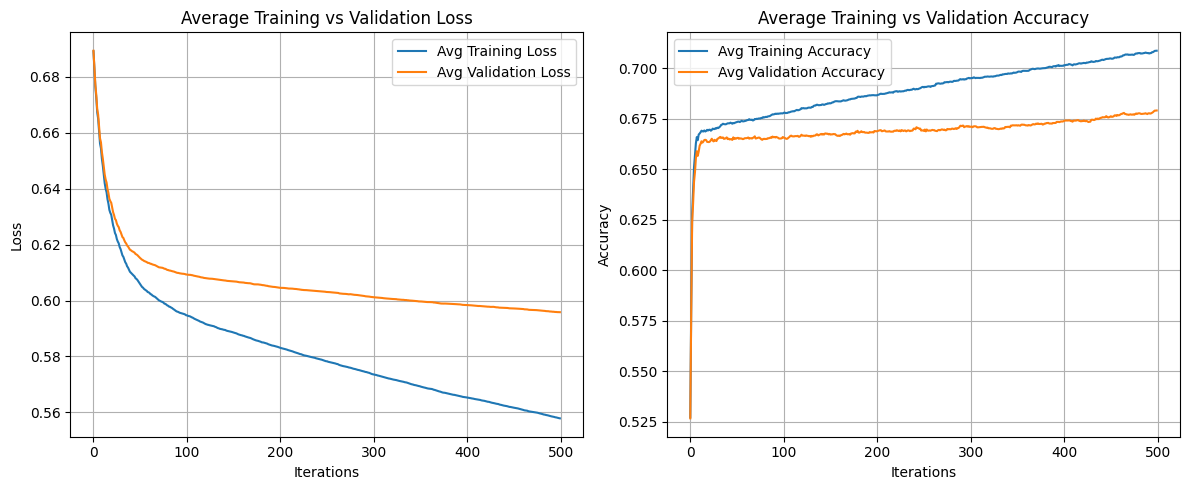


Training final model on all data...

Feature Importance Scores:
priors_count: 6.3
age: 4.4
sex_Female: 3.8
race_African-American: 3.8
sex_Male: 3.2
juv_other_count: 3.0
juv_misd_count: 2.7
race_Caucasian: 2.6
race_Other: 2.6
race_Hispanic: 2.4
juv_fel_count: 2.3
race_Asian: 1.9
race_Native American: 1.6


In [ ]:
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.calibration import CalibratedClassifierCV
import matplotlib.pyplot as plt
from xgboost import plot_importance
from xgboost.callback import TrainingCallback
import json
from graphviz import Digraph
from IPython.display import display

# Load and preprocess data
print("\nLoading and preprocessing data...")
data = pd.read_csv('cox-violent-parsed_filt.csv')

# Remove cases where is_recid is -1 (unknown/pending)
data = data[data['is_recid'] != -1].copy()

# Select specific features
X = data[["sex", 'age', 'race', 'juv_fel_count', 'juv_misd_count', 'juv_other_count',
          'priors_count', 'c_charge_degree']]
y = data['is_recid']

# Store original value ranges for denormalization
value_ranges = {}
for col in ['age', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count']:
    value_ranges[col] = {
        'min': float(X[col].min()),
        'max': float(X[col].max())
    }

# Save value ranges for visualization
with open('value_ranges.json', 'w') as f:
    json.dump(value_ranges, f)

# Fill missing values
X['c_charge_degree'] = X['c_charge_degree'].fillna('Unknown')

def categorize_charge_degree(x):
    if pd.isna(x) or x == 'Unknown':
        return 'Other'
    if str(x).startswith('F'):
        return 'Felony'
    if str(x).startswith('M'):
        return 'Misdemeanor'
    return 'Other'

X['c_charge_degree'] = X['c_charge_degree'].apply(categorize_charge_degree)

# Define categorical and numerical features
categorical_features = ['sex', 'race', 'c_charge_degree']
numerical_features = ['age', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count']

# One-hot encode categorical features
X_encoded = pd.get_dummies(X, columns=categorical_features)

# Clean up feature names
X_encoded.columns = [col.replace('[', '_').replace(']', '_').replace('<', '_').replace('>', '_')
                    for col in X_encoded.columns]

# Normalize numerical features
for col in numerical_features:
    if col in X_encoded.columns:
        min_val = X_encoded[col].min()
        max_val = X_encoded[col].max()
        if max_val > min_val:
            X_encoded[col] = (X_encoded[col] - min_val) / (max_val - min_val)

# Model parameters
params = {
    'objective': 'binary:logistic',
    'eval_metric': ['logloss', 'error', 'auc'],
    'eta': 0.05,
    'max_depth': 5,
    'min_child_weight': 2,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'scale_pos_weight': 1,
    'base_score': np.mean(y),
    'tree_method': 'hist'
}

# Initialize 5-fold cross validation
n_folds = 5
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
fold_scores = []

# Lists to store metrics for each fold
all_train_losses = []
all_val_losses = []
all_train_accuracies = []
all_val_accuracies = []

class MetricHistory(TrainingCallback):
    def __init__(self):
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []

    def after_iteration(self, model, epoch, evals_log):
        train_metrics = evals_log.get('train', {})
        eval_metrics = evals_log.get('eval', {})

        if 'logloss' in train_metrics:
            self.train_losses.append(train_metrics['logloss'][-1])
            self.val_losses.append(eval_metrics['logloss'][-1])

        if 'error' in train_metrics:
            self.train_accuracies.append(1 - train_metrics['error'][-1])
            self.val_accuracies.append(1 - eval_metrics['error'][-1])

        return False

def plot_training_metrics(train_metric, val_metric, metric_name, fold):
    plt.figure(figsize=(10, 6))
    plt.plot(train_metric, label=f'Training {metric_name}')
    plt.plot(val_metric, label=f'Validation {metric_name}')
    plt.xlabel('Iterations')
    plt.ylabel(metric_name)
    plt.title(f'Training vs Validation {metric_name} - Fold {fold+1}')
    plt.legend()
    plt.grid(True)
    plt.show()

print("\nStarting 5-fold cross-validation...")

for fold, (train_idx, val_idx) in enumerate(kf.split(X_encoded)):
    print(f"\nTraining fold {fold + 1}/{n_folds}")

    X_train, X_val = X_encoded.iloc[train_idx], X_encoded.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # Create DMatrix objects
    dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=X_encoded.columns.tolist())
    dval = xgb.DMatrix(X_val, label=y_val, feature_names=X_encoded.columns.tolist())
    evallist = [(dtrain, 'train'), (dval, 'eval')]

    # Initialize metric history
    metric_callback = MetricHistory()

    # Train the model
    model = xgb.train(
        params,
        dtrain,
        num_boost_round=500,
        early_stopping_rounds=50,
        evals=evallist,
        verbose_eval=100,
        callbacks=[metric_callback]
    )

    # Store metrics
    all_train_losses.append(metric_callback.train_losses)
    all_val_losses.append(metric_callback.val_losses)
    all_train_accuracies.append(metric_callback.train_accuracies)
    all_val_accuracies.append(metric_callback.val_accuracies)

    # Plot metrics for this fold
    plot_training_metrics(metric_callback.train_losses, metric_callback.val_losses, 'Loss', fold)
    plot_training_metrics(metric_callback.train_accuracies, metric_callback.val_accuracies, 'Accuracy', fold)

    # Calculate and store fold score
    val_pred = model.predict(dval)
    fold_accuracy = ((val_pred > 0.5) == y_val).mean()
    fold_scores.append(fold_accuracy)
    print(f"Fold {fold + 1} Validation Accuracy: {fold_accuracy:.4f}")

# Print overall cross-validation results
print("\nCross-validation Results:")
print(f"Mean Accuracy: {np.mean(fold_scores):.4f} (+/- {np.std(fold_scores):.4f})")

# Plot average metrics across all folds
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
mean_train_loss = np.mean(all_train_losses, axis=0)
mean_val_loss = np.mean(all_val_losses, axis=0)
plt.plot(mean_train_loss, label='Avg Training Loss')
plt.plot(mean_val_loss, label='Avg Validation Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Average Training vs Validation Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
mean_train_acc = np.mean(all_train_accuracies, axis=0)
mean_val_acc = np.mean(all_val_accuracies, axis=0)
plt.plot(mean_train_acc, label='Avg Training Accuracy')
plt.plot(mean_val_acc, label='Avg Validation Accuracy')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('Average Training vs Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Train final model on all data
print("\nTraining final model on all data...")
dtrain_full = xgb.DMatrix(X_encoded, label=y, feature_names=X_encoded.columns.tolist())
final_model = xgb.train(params, dtrain_full, num_boost_round=model.best_iteration)

# Save the final model
final_model.save_model('xgboost_model.json')

# Get feature importance scores
importance_type = 'gain'
scores = final_model.get_score(importance_type=importance_type)
feature_importance = pd.DataFrame({
    'feature': list(scores.keys()),
    'importance': list(scores.values())
}).sort_values('importance', ascending=False)

print("\nFeature Importance Scores:")
for idx, row in feature_importance.iterrows():
    print(f"{row['feature']}: {row['importance']:.1f}")

# Save feature importance to CSV
feature_importance.to_csv('feature_importance.csv', index=False)



## 5-Fold Cross Validation (Depth 4)


Loading and preprocessing data...

Starting 5-fold cross-validation...

Training fold 1/5
[0]	train-logloss:0.68946	train-error:0.47935	train-auc:0.63136	eval-logloss:0.68973	eval-error:0.48800	eval-auc:0.64778


/tmp/ipython-input-21-2495690678.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['c_charge_degree'] = X['c_charge_degree'].fillna('Unknown')
/tmp/ipython-input-21-2495690678.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['c_charge_degree'] = X['c_charge_degree'].apply(categorize_charge_degree)


[100]	train-logloss:0.60625	train-error:0.33245	train-auc:0.73182	eval-logloss:0.60580	eval-error:0.32543	eval-auc:0.73458
[200]	train-logloss:0.59824	train-error:0.32595	train-auc:0.74031	eval-logloss:0.60158	eval-error:0.32286	eval-auc:0.73886
[300]	train-logloss:0.59242	train-error:0.32088	train-auc:0.74663	eval-logloss:0.59896	eval-error:0.32143	eval-auc:0.74122
[400]	train-logloss:0.58634	train-error:0.31502	train-auc:0.75366	eval-logloss:0.59623	eval-error:0.32086	eval-auc:0.74423
[499]	train-logloss:0.58116	train-error:0.31323	train-auc:0.75933	eval-logloss:0.59438	eval-error:0.32029	eval-auc:0.74655


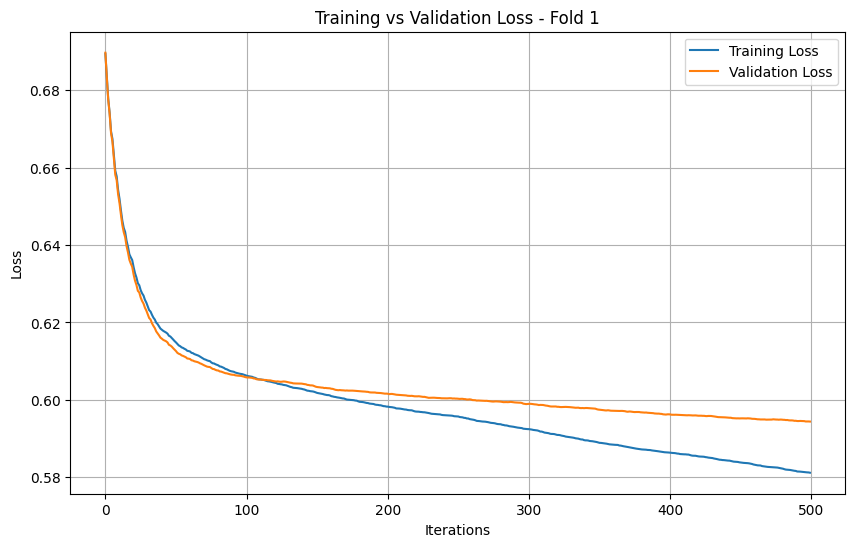

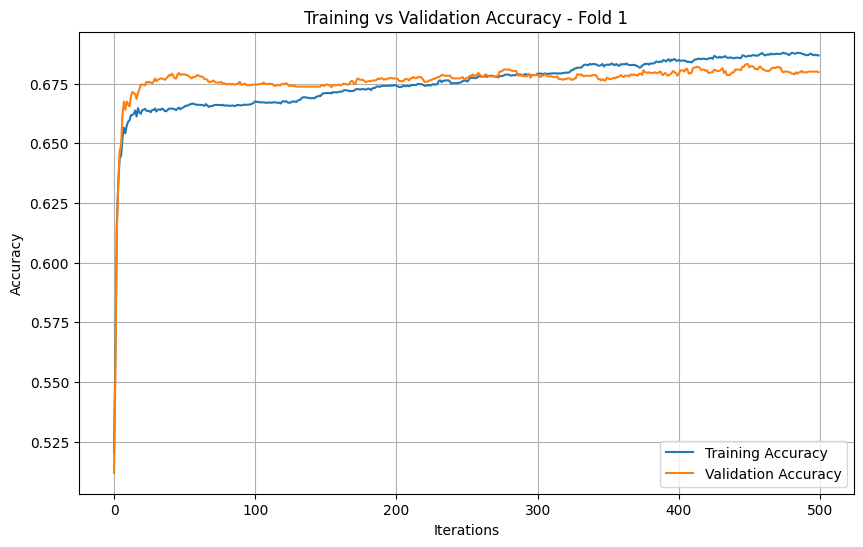

Fold 1 Validation Accuracy: 0.6797

Training fold 2/5
[0]	train-logloss:0.68927	train-error:0.48067	train-auc:0.63435	eval-logloss:0.68991	eval-error:0.48271	eval-auc:0.61376
[100]	train-logloss:0.60220	train-error:0.32771	train-auc:0.73715	eval-logloss:0.62286	eval-error:0.34467	eval-auc:0.71134
[200]	train-logloss:0.59347	train-error:0.32414	train-auc:0.74555	eval-logloss:0.62098	eval-error:0.34324	eval-auc:0.71532
[300]	train-logloss:0.58707	train-error:0.31592	train-auc:0.75255	eval-logloss:0.61984	eval-error:0.34153	eval-auc:0.71768
[400]	train-logloss:0.58101	train-error:0.31385	train-auc:0.75875	eval-logloss:0.61869	eval-error:0.34181	eval-auc:0.71983
[499]	train-logloss:0.57578	train-error:0.30892	train-auc:0.76429	eval-logloss:0.61707	eval-error:0.33981	eval-auc:0.72261


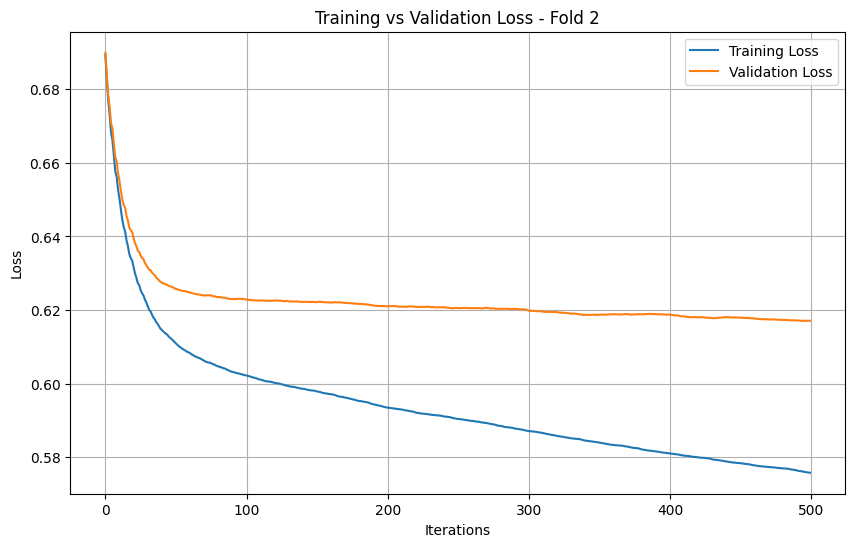

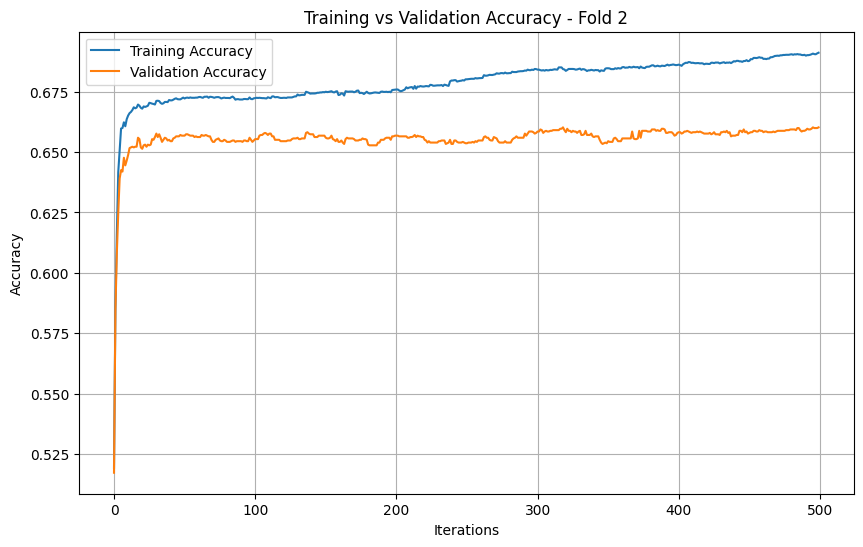

Fold 2 Validation Accuracy: 0.6602

Training fold 3/5
[0]	train-logloss:0.68940	train-error:0.47789	train-auc:0.63572	eval-logloss:0.68999	eval-error:0.48214	eval-auc:0.62578
[100]	train-logloss:0.60485	train-error:0.32986	train-auc:0.73430	eval-logloss:0.61343	eval-error:0.33610	eval-auc:0.72297
[200]	train-logloss:0.59726	train-error:0.32578	train-auc:0.74161	eval-logloss:0.61001	eval-error:0.33810	eval-auc:0.72625
[300]	train-logloss:0.59063	train-error:0.32121	train-auc:0.74908	eval-logloss:0.60763	eval-error:0.33638	eval-auc:0.72931
[400]	train-logloss:0.58455	train-error:0.31271	train-auc:0.75560	eval-logloss:0.60479	eval-error:0.33095	eval-auc:0.73319
[499]	train-logloss:0.57912	train-error:0.30964	train-auc:0.76161	eval-logloss:0.60263	eval-error:0.33352	eval-auc:0.73569


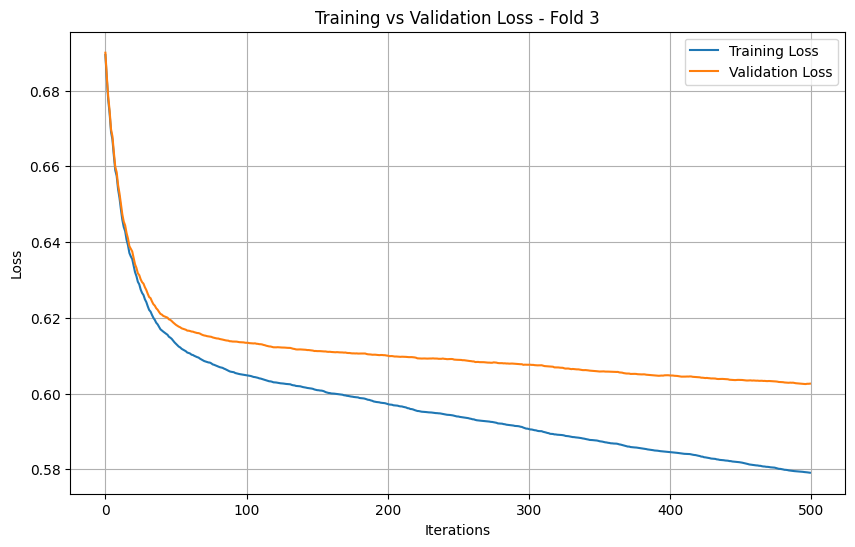

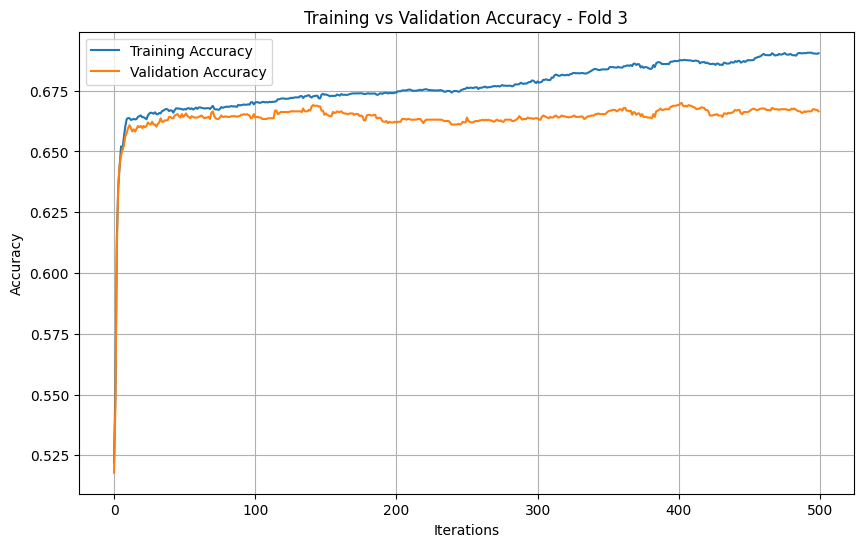

Fold 3 Validation Accuracy: 0.6665

Training fold 4/5
[0]	train-logloss:0.68923	train-error:0.46603	train-auc:0.63569	eval-logloss:0.69006	eval-error:0.47556	eval-auc:0.62758
[100]	train-logloss:0.60478	train-error:0.32971	train-auc:0.73352	eval-logloss:0.61385	eval-error:0.33810	eval-auc:0.72376
[200]	train-logloss:0.59671	train-error:0.32528	train-auc:0.74217	eval-logloss:0.61029	eval-error:0.33838	eval-auc:0.72736
[300]	train-logloss:0.58940	train-error:0.31578	train-auc:0.75000	eval-logloss:0.60725	eval-error:0.33467	eval-auc:0.73104
[400]	train-logloss:0.58379	train-error:0.31085	train-auc:0.75596	eval-logloss:0.60504	eval-error:0.33181	eval-auc:0.73402
[499]	train-logloss:0.57827	train-error:0.30785	train-auc:0.76204	eval-logloss:0.60363	eval-error:0.32638	eval-auc:0.73586


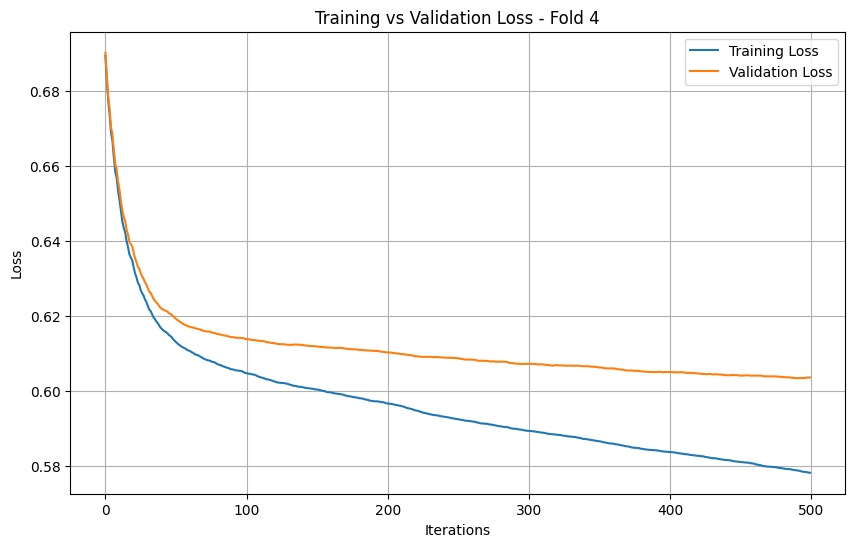

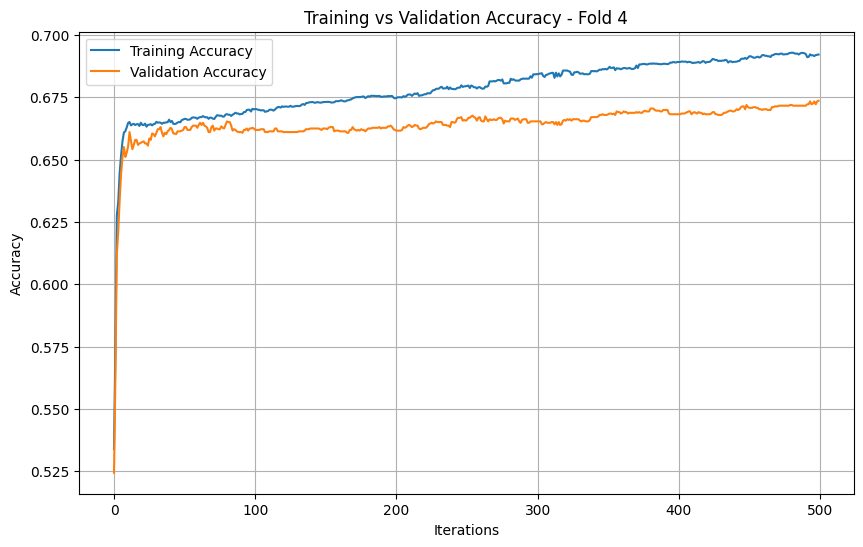

Fold 4 Validation Accuracy: 0.6736

Training fold 5/5
[0]	train-logloss:0.68979	train-error:0.48596	train-auc:0.63152	eval-logloss:0.68822	eval-error:0.46156	eval-auc:0.61960
[100]	train-logloss:0.60416	train-error:0.32743	train-auc:0.73578	eval-logloss:0.61418	eval-error:0.34353	eval-auc:0.72010
[200]	train-logloss:0.59560	train-error:0.32214	train-auc:0.74432	eval-logloss:0.61033	eval-error:0.34067	eval-auc:0.72384
[300]	train-logloss:0.58864	train-error:0.31907	train-auc:0.75211	eval-logloss:0.60766	eval-error:0.33753	eval-auc:0.72739
[400]	train-logloss:0.58225	train-error:0.31307	train-auc:0.75920	eval-logloss:0.60505	eval-error:0.33524	eval-auc:0.73069
[499]	train-logloss:0.57754	train-error:0.30792	train-auc:0.76434	eval-logloss:0.60375	eval-error:0.33524	eval-auc:0.73230


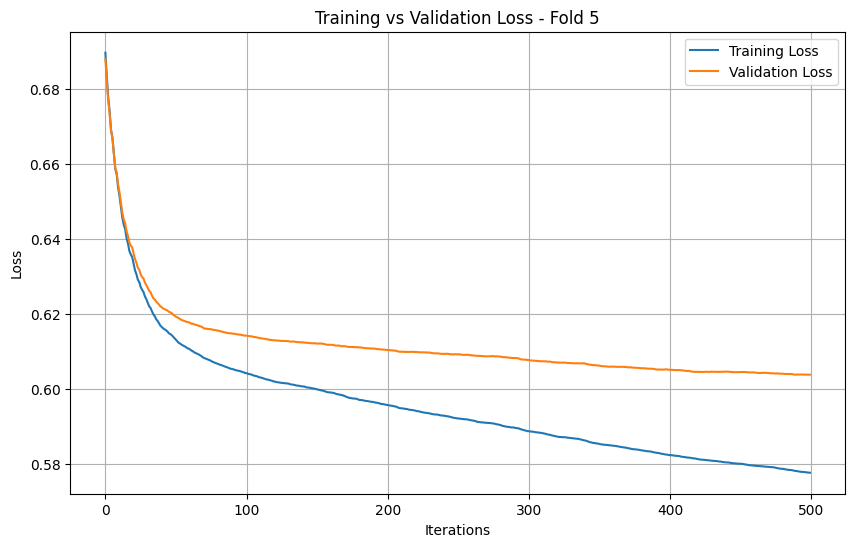

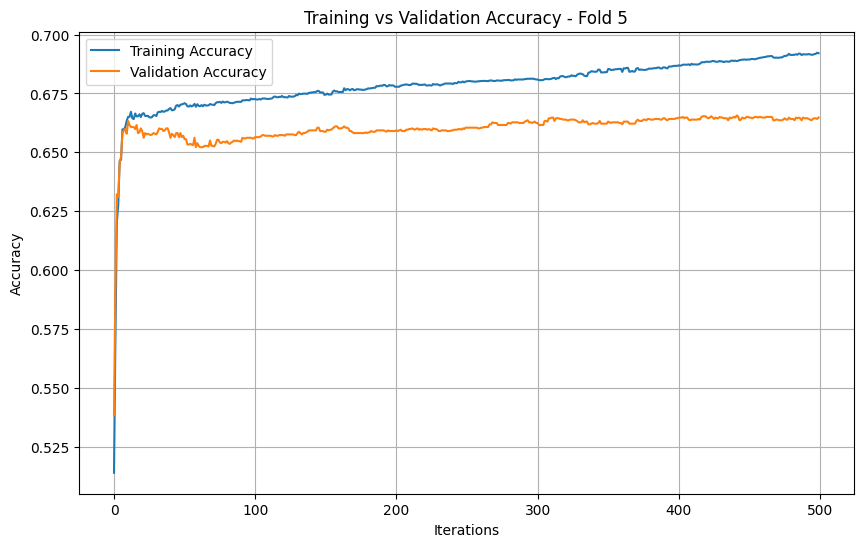

Fold 5 Validation Accuracy: 0.6648

Cross-validation Results:
Mean Accuracy: 0.6690 (+/- 0.0069)


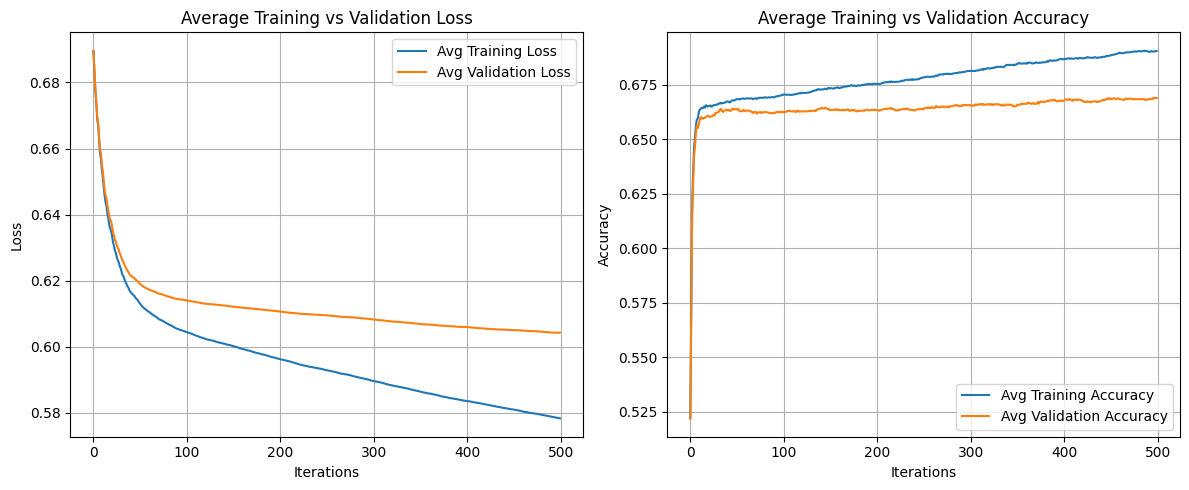


Training final model on all data...

Feature Importance Scores:
priors_count: 9.8
age: 6.3
sex_Female: 5.6
race_African-American: 5.2
sex_Male: 4.9
juv_other_count: 3.9
juv_misd_count: 3.6
race_Hispanic: 3.1
race_Other: 3.1
race_Caucasian: 3.0
juv_fel_count: 2.6
race_Native American: 2.0
race_Asian: 2.0


In [ ]:
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.calibration import CalibratedClassifierCV
import matplotlib.pyplot as plt
from xgboost import plot_importance
from xgboost.callback import TrainingCallback
import json
from graphviz import Digraph
from IPython.display import display

# Load and preprocess data
print("\nLoading and preprocessing data...")
data = pd.read_csv('cox-violent-parsed_filt.csv')

# Remove cases where is_recid is -1 (unknown/pending)
data = data[data['is_recid'] != -1].copy()

# Select specific features
X = data[["sex", 'age', 'race', 'juv_fel_count', 'juv_misd_count', 'juv_other_count',
          'priors_count', 'c_charge_degree']]
y = data['is_recid']

# Store original value ranges for denormalization
value_ranges = {}
for col in ['age', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count']:
    value_ranges[col] = {
        'min': float(X[col].min()),
        'max': float(X[col].max())
    }

# Save value ranges for visualization
with open('value_ranges.json', 'w') as f:
    json.dump(value_ranges, f)

# Fill missing values
X['c_charge_degree'] = X['c_charge_degree'].fillna('Unknown')

def categorize_charge_degree(x):
    if pd.isna(x) or x == 'Unknown':
        return 'Other'
    if str(x).startswith('F'):
        return 'Felony'
    if str(x).startswith('M'):
        return 'Misdemeanor'
    return 'Other'

X['c_charge_degree'] = X['c_charge_degree'].apply(categorize_charge_degree)

# Define categorical and numerical features
categorical_features = ['sex', 'race', 'c_charge_degree']
numerical_features = ['age', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count']

# One-hot encode categorical features
X_encoded = pd.get_dummies(X, columns=categorical_features)

# Clean up feature names
X_encoded.columns = [col.replace('[', '_').replace(']', '_').replace('<', '_').replace('>', '_')
                    for col in X_encoded.columns]

# Normalize numerical features
for col in numerical_features:
    if col in X_encoded.columns:
        min_val = X_encoded[col].min()
        max_val = X_encoded[col].max()
        if max_val > min_val:
            X_encoded[col] = (X_encoded[col] - min_val) / (max_val - min_val)

# Model parameters
params = {
    'objective': 'binary:logistic',
    'eval_metric': ['logloss', 'error', 'auc'],
    'eta': 0.05,
    'max_depth': 4,
    'min_child_weight': 2,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'scale_pos_weight': 1,
    'base_score': np.mean(y),
    'tree_method': 'hist'
}

# Initialize 5-fold cross validation
n_folds = 5
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
fold_scores = []

# Lists to store metrics for each fold
all_train_losses = []
all_val_losses = []
all_train_accuracies = []
all_val_accuracies = []

class MetricHistory(TrainingCallback):
    def __init__(self):
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []

    def after_iteration(self, model, epoch, evals_log):
        train_metrics = evals_log.get('train', {})
        eval_metrics = evals_log.get('eval', {})

        if 'logloss' in train_metrics:
            self.train_losses.append(train_metrics['logloss'][-1])
            self.val_losses.append(eval_metrics['logloss'][-1])

        if 'error' in train_metrics:
            self.train_accuracies.append(1 - train_metrics['error'][-1])
            self.val_accuracies.append(1 - eval_metrics['error'][-1])

        return False

def plot_training_metrics(train_metric, val_metric, metric_name, fold):
    plt.figure(figsize=(10, 6))
    plt.plot(train_metric, label=f'Training {metric_name}')
    plt.plot(val_metric, label=f'Validation {metric_name}')
    plt.xlabel('Iterations')
    plt.ylabel(metric_name)
    plt.title(f'Training vs Validation {metric_name} - Fold {fold+1}')
    plt.legend()
    plt.grid(True)
    plt.show()

print("\nStarting 5-fold cross-validation...")

for fold, (train_idx, val_idx) in enumerate(kf.split(X_encoded)):
    print(f"\nTraining fold {fold + 1}/{n_folds}")

    X_train, X_val = X_encoded.iloc[train_idx], X_encoded.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # Create DMatrix objects
    dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=X_encoded.columns.tolist())
    dval = xgb.DMatrix(X_val, label=y_val, feature_names=X_encoded.columns.tolist())
    evallist = [(dtrain, 'train'), (dval, 'eval')]

    # Initialize metric history
    metric_callback = MetricHistory()

    # Train the model
    model = xgb.train(
        params,
        dtrain,
        num_boost_round=500,
        early_stopping_rounds=50,
        evals=evallist,
        verbose_eval=100,
        callbacks=[metric_callback]
    )

    # Store metrics
    all_train_losses.append(metric_callback.train_losses)
    all_val_losses.append(metric_callback.val_losses)
    all_train_accuracies.append(metric_callback.train_accuracies)
    all_val_accuracies.append(metric_callback.val_accuracies)

    # Plot metrics for this fold
    plot_training_metrics(metric_callback.train_losses, metric_callback.val_losses, 'Loss', fold)
    plot_training_metrics(metric_callback.train_accuracies, metric_callback.val_accuracies, 'Accuracy', fold)

    # Calculate and store fold score
    val_pred = model.predict(dval)
    fold_accuracy = ((val_pred > 0.5) == y_val).mean()
    fold_scores.append(fold_accuracy)
    print(f"Fold {fold + 1} Validation Accuracy: {fold_accuracy:.4f}")

# Print overall cross-validation results
print("\nCross-validation Results:")
print(f"Mean Accuracy: {np.mean(fold_scores):.4f} (+/- {np.std(fold_scores):.4f})")

# Plot average metrics across all folds
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
mean_train_loss = np.mean(all_train_losses, axis=0)
mean_val_loss = np.mean(all_val_losses, axis=0)
plt.plot(mean_train_loss, label='Avg Training Loss')
plt.plot(mean_val_loss, label='Avg Validation Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Average Training vs Validation Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
mean_train_acc = np.mean(all_train_accuracies, axis=0)
mean_val_acc = np.mean(all_val_accuracies, axis=0)
plt.plot(mean_train_acc, label='Avg Training Accuracy')
plt.plot(mean_val_acc, label='Avg Validation Accuracy')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('Average Training vs Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Train final model on all data
print("\nTraining final model on all data...")
dtrain_full = xgb.DMatrix(X_encoded, label=y, feature_names=X_encoded.columns.tolist())
final_model = xgb.train(params, dtrain_full, num_boost_round=model.best_iteration)

# Save the final model
final_model.save_model('xgboost_model.json')

# Get feature importance scores
importance_type = 'gain'
scores = final_model.get_score(importance_type=importance_type)
feature_importance = pd.DataFrame({
    'feature': list(scores.keys()),
    'importance': list(scores.values())
}).sort_values('importance', ascending=False)

print("\nFeature Importance Scores:")
for idx, row in feature_importance.iterrows():
    print(f"{row['feature']}: {row['importance']:.1f}")

# Save feature importance to CSV
feature_importance.to_csv('feature_importance.csv', index=False)



## 5-Fold Cross Validation (Depth 3)


Loading and preprocessing data...

Starting 5-fold cross-validation...

Training fold 1/5
[0]	train-logloss:0.69006	train-error:0.47935	train-auc:0.61689	eval-logloss:0.69050	eval-error:0.48800	eval-auc:0.62558


/tmp/ipython-input-22-3612043176.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['c_charge_degree'] = X['c_charge_degree'].fillna('Unknown')
/tmp/ipython-input-22-3612043176.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['c_charge_degree'] = X['c_charge_degree'].apply(categorize_charge_degree)


[100]	train-logloss:0.61398	train-error:0.33753	train-auc:0.72269	eval-logloss:0.61050	eval-error:0.32514	eval-auc:0.72956
[200]	train-logloss:0.60852	train-error:0.33631	train-auc:0.72820	eval-logloss:0.60718	eval-error:0.32571	eval-auc:0.73237
[300]	train-logloss:0.60495	train-error:0.33338	train-auc:0.73207	eval-logloss:0.60548	eval-error:0.32400	eval-auc:0.73390
[400]	train-logloss:0.60164	train-error:0.33009	train-auc:0.73588	eval-logloss:0.60394	eval-error:0.32343	eval-auc:0.73581
[499]	train-logloss:0.59861	train-error:0.32852	train-auc:0.73909	eval-logloss:0.60234	eval-error:0.32200	eval-auc:0.73730


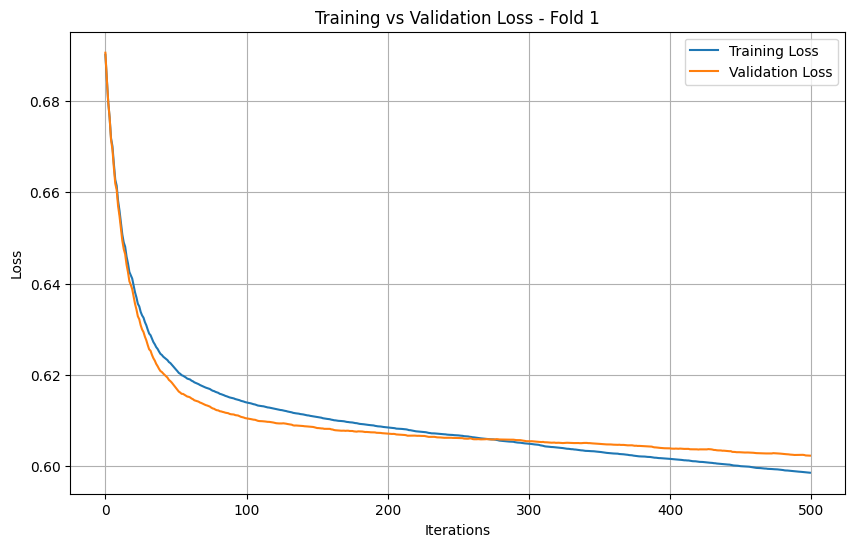

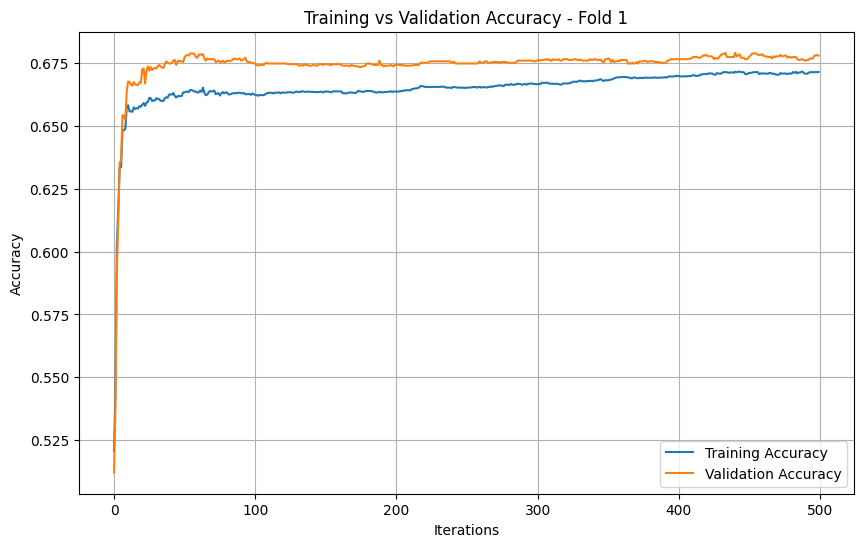

Fold 1 Validation Accuracy: 0.6780

Training fold 2/5
[0]	train-logloss:0.68986	train-error:0.48067	train-auc:0.61864	eval-logloss:0.69041	eval-error:0.48271	eval-auc:0.60186
[100]	train-logloss:0.61010	train-error:0.33229	train-auc:0.72768	eval-logloss:0.62559	eval-error:0.34610	eval-auc:0.70739
[200]	train-logloss:0.60446	train-error:0.33079	train-auc:0.73292	eval-logloss:0.62465	eval-error:0.34839	eval-auc:0.70978
[300]	train-logloss:0.60029	train-error:0.33129	train-auc:0.73763	eval-logloss:0.62415	eval-error:0.35067	eval-auc:0.71125
[400]	train-logloss:0.59645	train-error:0.32721	train-auc:0.74184	eval-logloss:0.62303	eval-error:0.34981	eval-auc:0.71340
[499]	train-logloss:0.59332	train-error:0.32421	train-auc:0.74516	eval-logloss:0.62255	eval-error:0.34524	eval-auc:0.71467


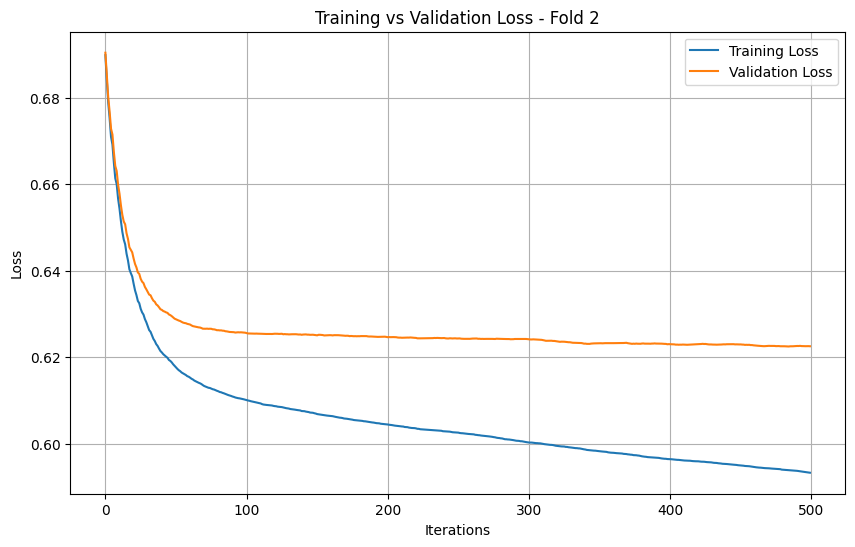

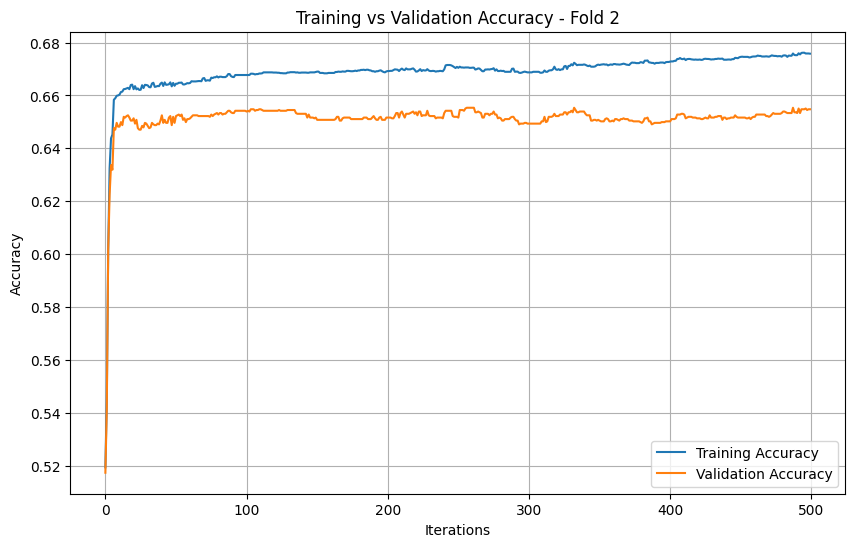

Fold 2 Validation Accuracy: 0.6548

Training fold 3/5
[0]	train-logloss:0.68993	train-error:0.48003	train-auc:0.61903	eval-logloss:0.69047	eval-error:0.48528	eval-auc:0.61203
[100]	train-logloss:0.61279	train-error:0.33429	train-auc:0.72452	eval-logloss:0.61771	eval-error:0.33753	eval-auc:0.71808
[200]	train-logloss:0.60724	train-error:0.33300	train-auc:0.73000	eval-logloss:0.61495	eval-error:0.33581	eval-auc:0.72094
[300]	train-logloss:0.60331	train-error:0.33179	train-auc:0.73432	eval-logloss:0.61326	eval-error:0.33410	eval-auc:0.72305
[400]	train-logloss:0.59958	train-error:0.32786	train-auc:0.73840	eval-logloss:0.61167	eval-error:0.33295	eval-auc:0.72498
[499]	train-logloss:0.59622	train-error:0.32650	train-auc:0.74224	eval-logloss:0.61037	eval-error:0.33638	eval-auc:0.72667


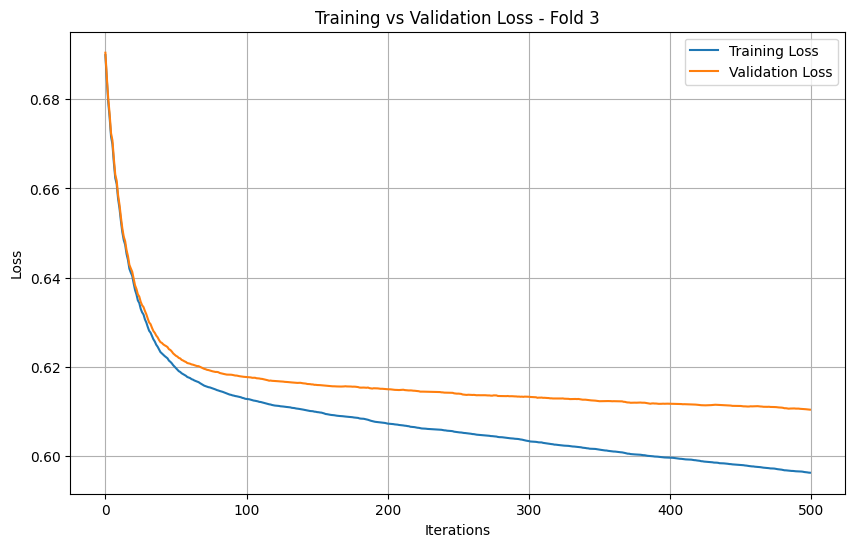

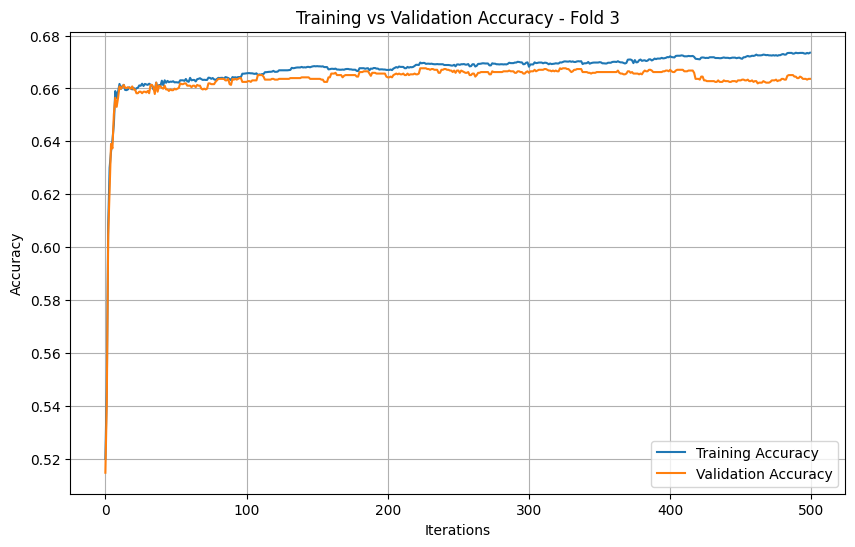

Fold 3 Validation Accuracy: 0.6636

Training fold 4/5
[0]	train-logloss:0.68985	train-error:0.47939	train-auc:0.62163	eval-logloss:0.69074	eval-error:0.48785	eval-auc:0.61118
[100]	train-logloss:0.61248	train-error:0.33536	train-auc:0.72401	eval-logloss:0.61774	eval-error:0.33781	eval-auc:0.71837
[200]	train-logloss:0.60697	train-error:0.33236	train-auc:0.72987	eval-logloss:0.61474	eval-error:0.33352	eval-auc:0.72164
[300]	train-logloss:0.60257	train-error:0.33007	train-auc:0.73491	eval-logloss:0.61271	eval-error:0.33867	eval-auc:0.72390
[400]	train-logloss:0.59928	train-error:0.32736	train-auc:0.73871	eval-logloss:0.61192	eval-error:0.33895	eval-auc:0.72505
[499]	train-logloss:0.59595	train-error:0.32550	train-auc:0.74241	eval-logloss:0.61109	eval-error:0.33781	eval-auc:0.72660


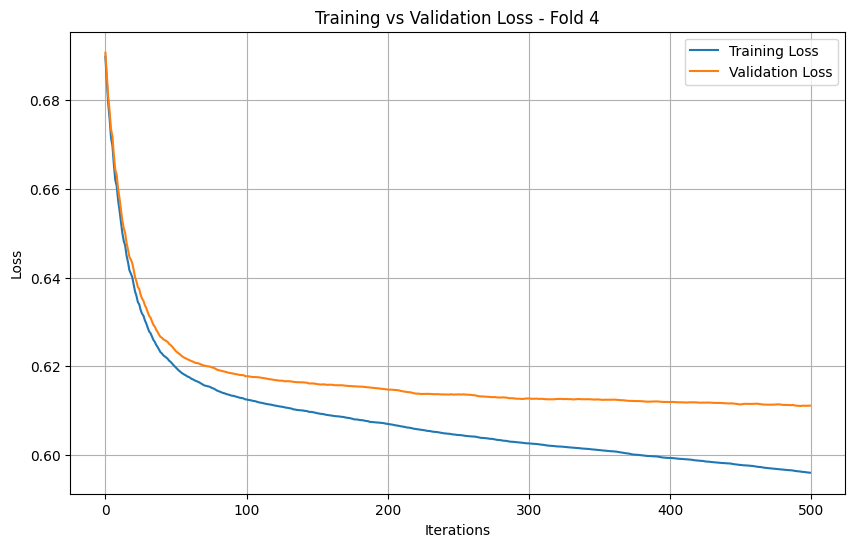

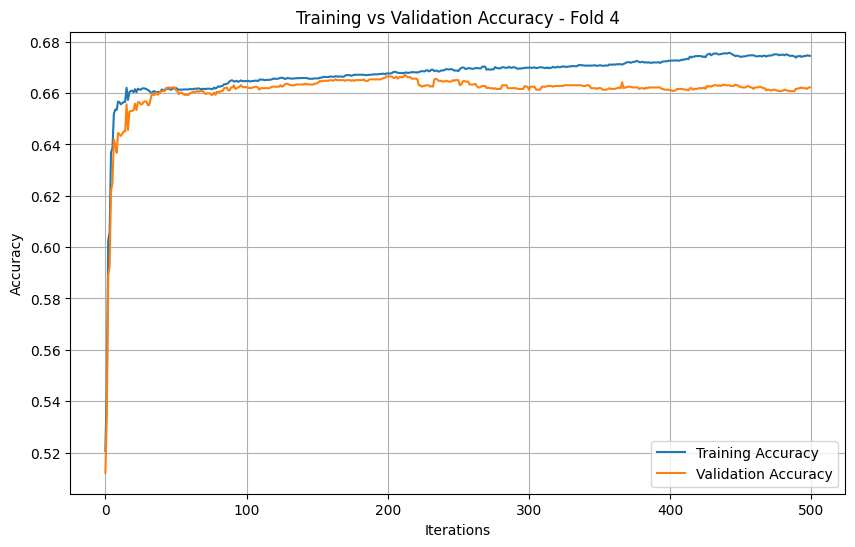

Fold 4 Validation Accuracy: 0.6622

Training fold 5/5
[0]	train-logloss:0.69031	train-error:0.48596	train-auc:0.61446	eval-logloss:0.68875	eval-error:0.46156	eval-auc:0.59797
[100]	train-logloss:0.61183	train-error:0.33386	train-auc:0.72629	eval-logloss:0.61832	eval-error:0.34496	eval-auc:0.71493
[200]	train-logloss:0.60574	train-error:0.33157	train-auc:0.73268	eval-logloss:0.61591	eval-error:0.34581	eval-auc:0.71761
[300]	train-logloss:0.60150	train-error:0.32700	train-auc:0.73734	eval-logloss:0.61471	eval-error:0.34210	eval-auc:0.71922
[400]	train-logloss:0.59784	train-error:0.32393	train-auc:0.74157	eval-logloss:0.61358	eval-error:0.34267	eval-auc:0.72057
[499]	train-logloss:0.59472	train-error:0.32343	train-auc:0.74513	eval-logloss:0.61225	eval-error:0.34210	eval-auc:0.72246


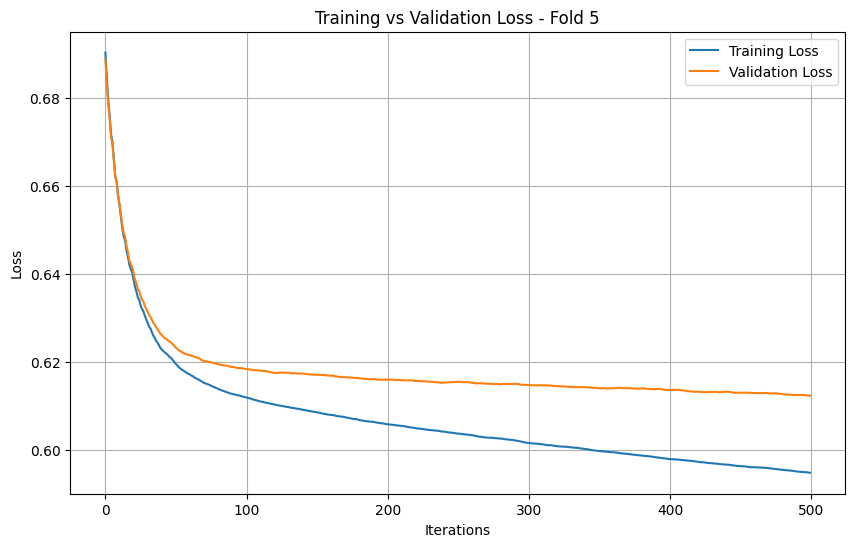

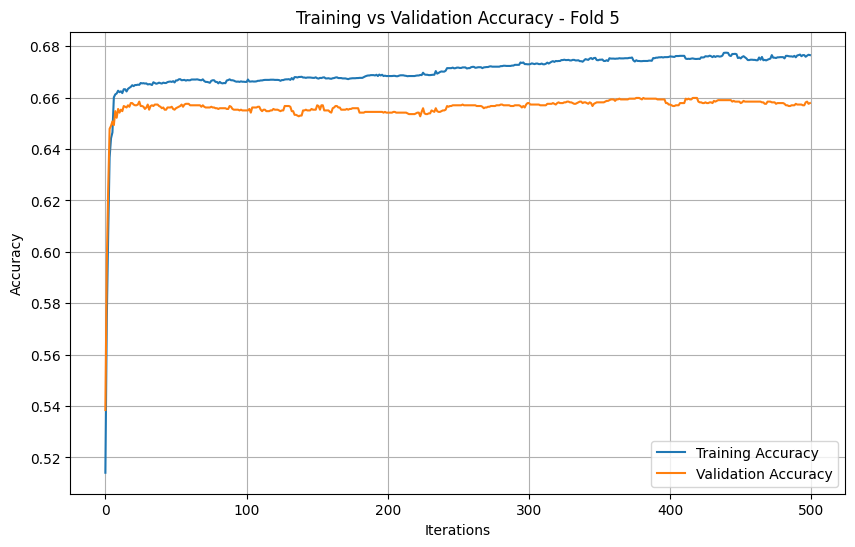

Fold 5 Validation Accuracy: 0.6579

Cross-validation Results:
Mean Accuracy: 0.6633 (+/- 0.0080)


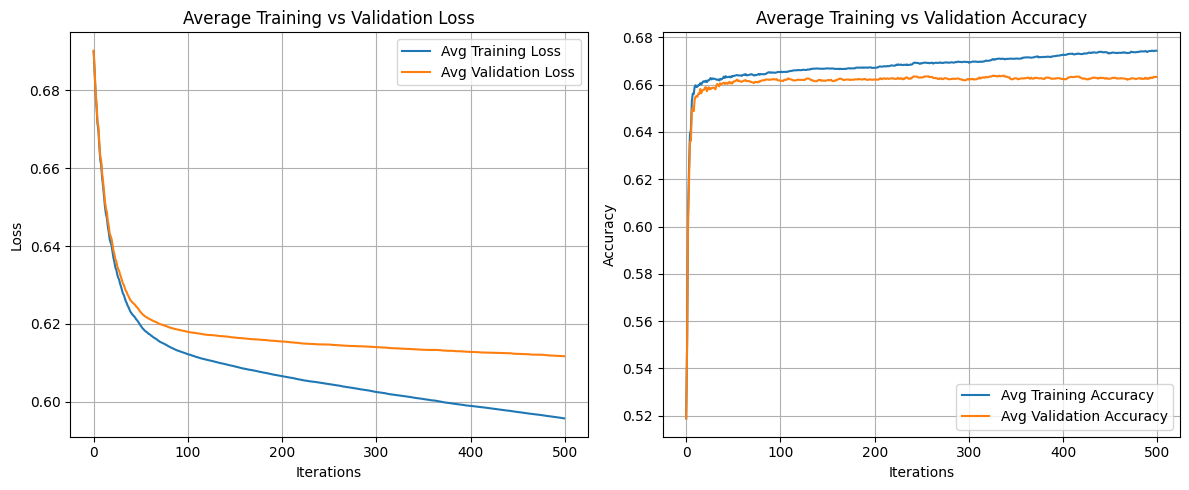


Training final model on all data...

Feature Importance Scores:
priors_count: 16.3
age: 9.8
sex_Female: 8.7
sex_Male: 7.7
race_African-American: 6.5
juv_other_count: 5.7
race_Hispanic: 4.7
juv_misd_count: 4.5
race_Other: 3.9
juv_fel_count: 3.5
race_Caucasian: 3.2
race_Asian: 2.5
race_Native American: 2.4


In [ ]:
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.calibration import CalibratedClassifierCV
import matplotlib.pyplot as plt
from xgboost import plot_importance
from xgboost.callback import TrainingCallback
import json
from graphviz import Digraph
from IPython.display import display

# Load and preprocess data
print("\nLoading and preprocessing data...")
data = pd.read_csv('cox-violent-parsed_filt.csv')

# Remove cases where is_recid is -1 (unknown/pending)
data = data[data['is_recid'] != -1].copy()

# Select specific features
X = data[["sex", 'age', 'race', 'juv_fel_count', 'juv_misd_count', 'juv_other_count',
          'priors_count', 'c_charge_degree']]
y = data['is_recid']

# Store original value ranges for denormalization
value_ranges = {}
for col in ['age', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count']:
    value_ranges[col] = {
        'min': float(X[col].min()),
        'max': float(X[col].max())
    }

# Save value ranges for visualization
with open('value_ranges.json', 'w') as f:
    json.dump(value_ranges, f)

# Fill missing values
X['c_charge_degree'] = X['c_charge_degree'].fillna('Unknown')

def categorize_charge_degree(x):
    if pd.isna(x) or x == 'Unknown':
        return 'Other'
    if str(x).startswith('F'):
        return 'Felony'
    if str(x).startswith('M'):
        return 'Misdemeanor'
    return 'Other'

X['c_charge_degree'] = X['c_charge_degree'].apply(categorize_charge_degree)

# Define categorical and numerical features
categorical_features = ['sex', 'race', 'c_charge_degree']
numerical_features = ['age', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count']

# One-hot encode categorical features
X_encoded = pd.get_dummies(X, columns=categorical_features)

# Clean up feature names
X_encoded.columns = [col.replace('[', '_').replace(']', '_').replace('<', '_').replace('>', '_')
                    for col in X_encoded.columns]

# Normalize numerical features
for col in numerical_features:
    if col in X_encoded.columns:
        min_val = X_encoded[col].min()
        max_val = X_encoded[col].max()
        if max_val > min_val:
            X_encoded[col] = (X_encoded[col] - min_val) / (max_val - min_val)

# Model parameters
params = {
    'objective': 'binary:logistic',
    'eval_metric': ['logloss', 'error', 'auc'],
    'eta': 0.05,
    'max_depth': 3,
    'min_child_weight': 2,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'scale_pos_weight': 1,
    'base_score': np.mean(y),
    'tree_method': 'hist'
}

# Initialize 5-fold cross validation
n_folds = 5
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
fold_scores = []

# Lists to store metrics for each fold
all_train_losses = []
all_val_losses = []
all_train_accuracies = []
all_val_accuracies = []

class MetricHistory(TrainingCallback):
    def __init__(self):
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []

    def after_iteration(self, model, epoch, evals_log):
        train_metrics = evals_log.get('train', {})
        eval_metrics = evals_log.get('eval', {})

        if 'logloss' in train_metrics:
            self.train_losses.append(train_metrics['logloss'][-1])
            self.val_losses.append(eval_metrics['logloss'][-1])

        if 'error' in train_metrics:
            self.train_accuracies.append(1 - train_metrics['error'][-1])
            self.val_accuracies.append(1 - eval_metrics['error'][-1])

        return False

def plot_training_metrics(train_metric, val_metric, metric_name, fold):
    plt.figure(figsize=(10, 6))
    plt.plot(train_metric, label=f'Training {metric_name}')
    plt.plot(val_metric, label=f'Validation {metric_name}')
    plt.xlabel('Iterations')
    plt.ylabel(metric_name)
    plt.title(f'Training vs Validation {metric_name} - Fold {fold+1}')
    plt.legend()
    plt.grid(True)
    plt.show()

print("\nStarting 5-fold cross-validation...")

for fold, (train_idx, val_idx) in enumerate(kf.split(X_encoded)):
    print(f"\nTraining fold {fold + 1}/{n_folds}")

    X_train, X_val = X_encoded.iloc[train_idx], X_encoded.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # Create DMatrix objects
    dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=X_encoded.columns.tolist())
    dval = xgb.DMatrix(X_val, label=y_val, feature_names=X_encoded.columns.tolist())
    evallist = [(dtrain, 'train'), (dval, 'eval')]

    # Initialize metric history
    metric_callback = MetricHistory()

    # Train the model
    model = xgb.train(
        params,
        dtrain,
        num_boost_round=500,
        early_stopping_rounds=50,
        evals=evallist,
        verbose_eval=100,
        callbacks=[metric_callback]
    )

    # Store metrics
    all_train_losses.append(metric_callback.train_losses)
    all_val_losses.append(metric_callback.val_losses)
    all_train_accuracies.append(metric_callback.train_accuracies)
    all_val_accuracies.append(metric_callback.val_accuracies)

    # Plot metrics for this fold
    plot_training_metrics(metric_callback.train_losses, metric_callback.val_losses, 'Loss', fold)
    plot_training_metrics(metric_callback.train_accuracies, metric_callback.val_accuracies, 'Accuracy', fold)

    # Calculate and store fold score
    val_pred = model.predict(dval)
    fold_accuracy = ((val_pred > 0.5) == y_val).mean()
    fold_scores.append(fold_accuracy)
    print(f"Fold {fold + 1} Validation Accuracy: {fold_accuracy:.4f}")

# Print overall cross-validation results
print("\nCross-validation Results:")
print(f"Mean Accuracy: {np.mean(fold_scores):.4f} (+/- {np.std(fold_scores):.4f})")

# Plot average metrics across all folds
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
mean_train_loss = np.mean(all_train_losses, axis=0)
mean_val_loss = np.mean(all_val_losses, axis=0)
plt.plot(mean_train_loss, label='Avg Training Loss')
plt.plot(mean_val_loss, label='Avg Validation Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Average Training vs Validation Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
mean_train_acc = np.mean(all_train_accuracies, axis=0)
mean_val_acc = np.mean(all_val_accuracies, axis=0)
plt.plot(mean_train_acc, label='Avg Training Accuracy')
plt.plot(mean_val_acc, label='Avg Validation Accuracy')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('Average Training vs Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Train final model on all data
print("\nTraining final model on all data...")
dtrain_full = xgb.DMatrix(X_encoded, label=y, feature_names=X_encoded.columns.tolist())
final_model = xgb.train(params, dtrain_full, num_boost_round=model.best_iteration)

# Save the final model
final_model.save_model('xgboost_model.json')

# Get feature importance scores
importance_type = 'gain'
scores = final_model.get_score(importance_type=importance_type)
feature_importance = pd.DataFrame({
    'feature': list(scores.keys()),
    'importance': list(scores.values())
}).sort_values('importance', ascending=False)

print("\nFeature Importance Scores:")
for idx, row in feature_importance.iterrows():
    print(f"{row['feature']}: {row['importance']:.1f}")

# Save feature importance to CSV
feature_importance.to_csv('feature_importance.csv', index=False)



## 5-Fold Cross Validation (Depth 2)


Loading and preprocessing data...

Starting 5-fold cross-validation...

Training fold 1/5
[0]	train-logloss:0.69050	train-error:0.47935	train-auc:0.59751	eval-logloss:0.69103	eval-error:0.48800	eval-auc:0.60376


/tmp/ipython-input-23-2551956552.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['c_charge_degree'] = X['c_charge_degree'].fillna('Unknown')
/tmp/ipython-input-23-2551956552.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['c_charge_degree'] = X['c_charge_degree'].apply(categorize_charge_degree)


[100]	train-logloss:0.61982	train-error:0.33681	train-auc:0.71597	eval-logloss:0.61585	eval-error:0.32143	eval-auc:0.72384
[200]	train-logloss:0.61553	train-error:0.33824	train-auc:0.71969	eval-logloss:0.61212	eval-error:0.32629	eval-auc:0.72609
[300]	train-logloss:0.61329	train-error:0.33795	train-auc:0.72216	eval-logloss:0.61070	eval-error:0.32829	eval-auc:0.72741
[400]	train-logloss:0.61158	train-error:0.33753	train-auc:0.72392	eval-logloss:0.60976	eval-error:0.33000	eval-auc:0.72844
[499]	train-logloss:0.61021	train-error:0.33753	train-auc:0.72539	eval-logloss:0.60899	eval-error:0.33343	eval-auc:0.72933


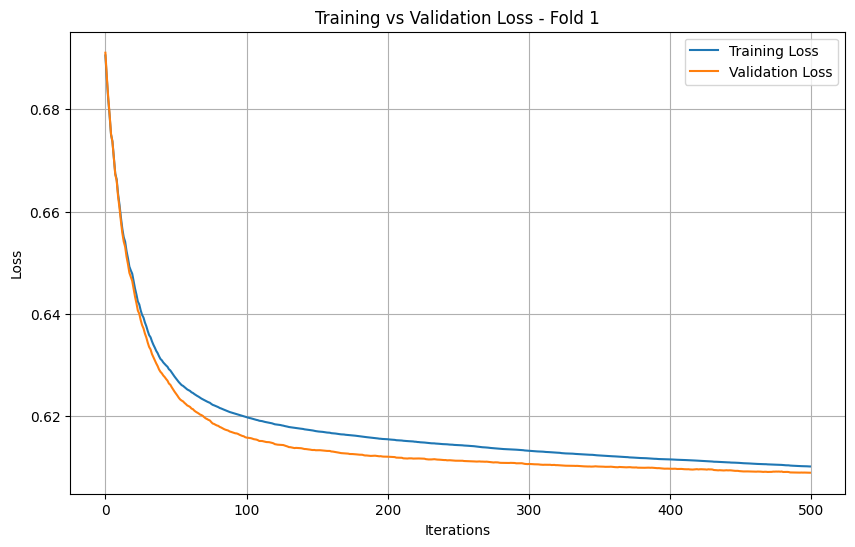

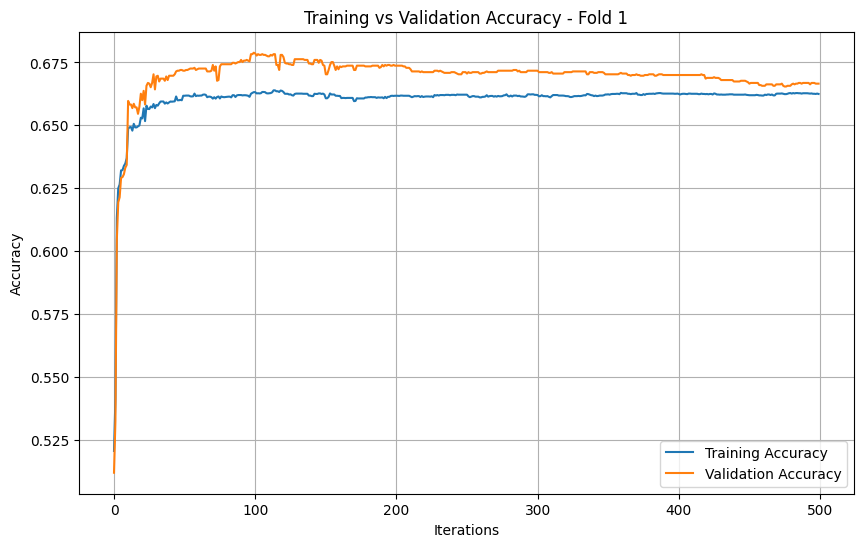

Fold 1 Validation Accuracy: 0.6666

Training fold 2/5
[0]	train-logloss:0.69045	train-error:0.48067	train-auc:0.59668	eval-logloss:0.69082	eval-error:0.48271	eval-auc:0.58597
[100]	train-logloss:0.61660	train-error:0.33600	train-auc:0.72090	eval-logloss:0.62747	eval-error:0.34981	eval-auc:0.70454
[200]	train-logloss:0.61190	train-error:0.33407	train-auc:0.72465	eval-logloss:0.62631	eval-error:0.34953	eval-auc:0.70660
[300]	train-logloss:0.60956	train-error:0.33307	train-auc:0.72696	eval-logloss:0.62643	eval-error:0.34981	eval-auc:0.70697
[400]	train-logloss:0.60775	train-error:0.33343	train-auc:0.72898	eval-logloss:0.62630	eval-error:0.35067	eval-auc:0.70752
[499]	train-logloss:0.60624	train-error:0.33407	train-auc:0.73066	eval-logloss:0.62617	eval-error:0.35124	eval-auc:0.70806


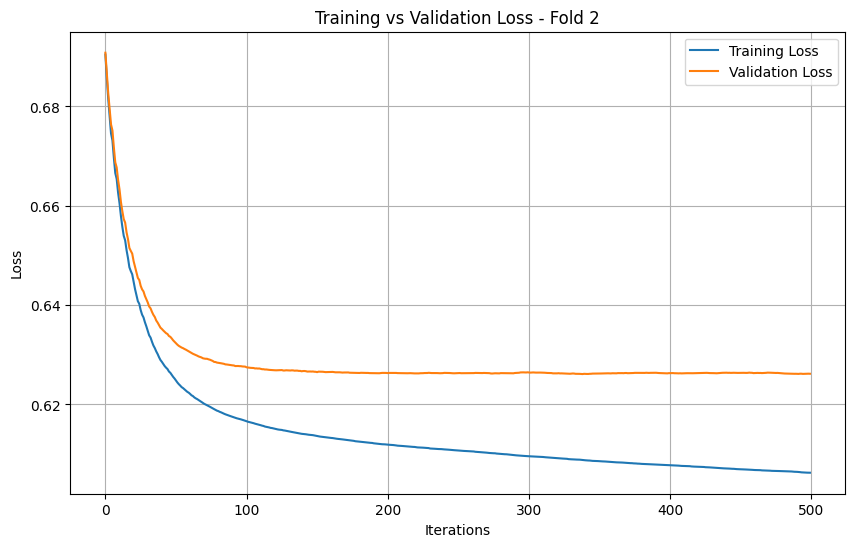

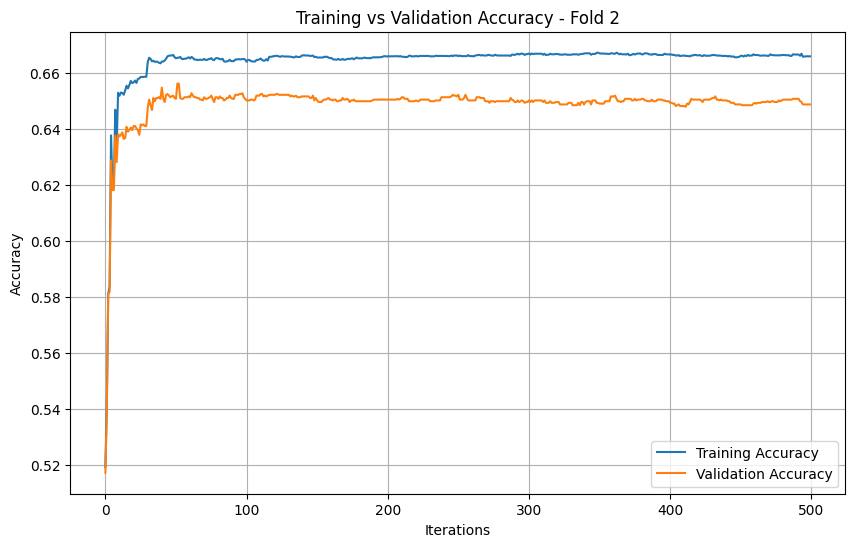

Fold 2 Validation Accuracy: 0.6488

Training fold 3/5
[0]	train-logloss:0.69045	train-error:0.48003	train-auc:0.59853	eval-logloss:0.69091	eval-error:0.48528	eval-auc:0.59597
[100]	train-logloss:0.61829	train-error:0.33636	train-auc:0.71819	eval-logloss:0.62124	eval-error:0.33381	eval-auc:0.71452
[200]	train-logloss:0.61408	train-error:0.33657	train-auc:0.72176	eval-logloss:0.61879	eval-error:0.33495	eval-auc:0.71657
[300]	train-logloss:0.61186	train-error:0.33543	train-auc:0.72423	eval-logloss:0.61783	eval-error:0.33467	eval-auc:0.71764
[400]	train-logloss:0.61012	train-error:0.33371	train-auc:0.72607	eval-logloss:0.61700	eval-error:0.33467	eval-auc:0.71873
[499]	train-logloss:0.60859	train-error:0.33279	train-auc:0.72781	eval-logloss:0.61624	eval-error:0.33981	eval-auc:0.71981


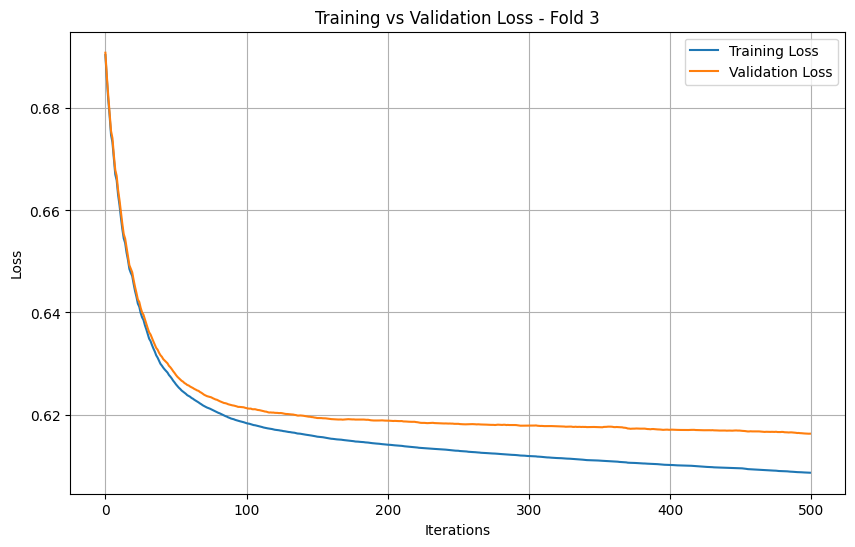

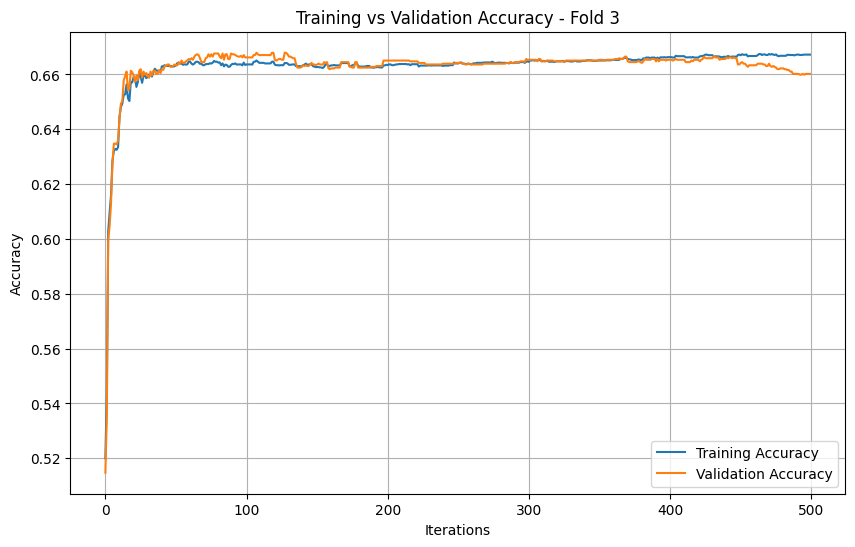

Fold 3 Validation Accuracy: 0.6602

Training fold 4/5
[0]	train-logloss:0.69035	train-error:0.47939	train-auc:0.59915	eval-logloss:0.69115	eval-error:0.48785	eval-auc:0.58993
[100]	train-logloss:0.61837	train-error:0.33772	train-auc:0.71770	eval-logloss:0.62182	eval-error:0.34010	eval-auc:0.71397
[200]	train-logloss:0.61427	train-error:0.33736	train-auc:0.72119	eval-logloss:0.61844	eval-error:0.33724	eval-auc:0.71647
[300]	train-logloss:0.61211	train-error:0.33593	train-auc:0.72322	eval-logloss:0.61715	eval-error:0.33895	eval-auc:0.71762
[400]	train-logloss:0.61032	train-error:0.33643	train-auc:0.72523	eval-logloss:0.61621	eval-error:0.33638	eval-auc:0.71890
[499]	train-logloss:0.60883	train-error:0.33529	train-auc:0.72686	eval-logloss:0.61571	eval-error:0.33610	eval-auc:0.71971


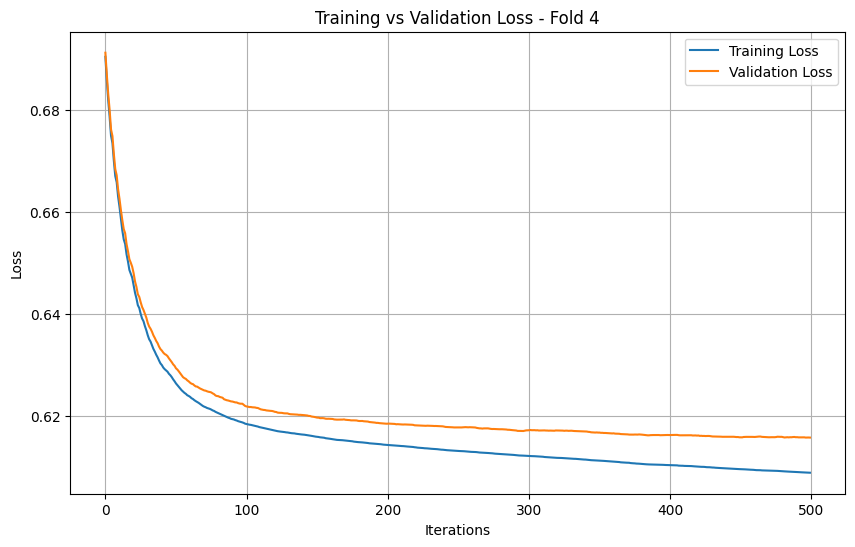

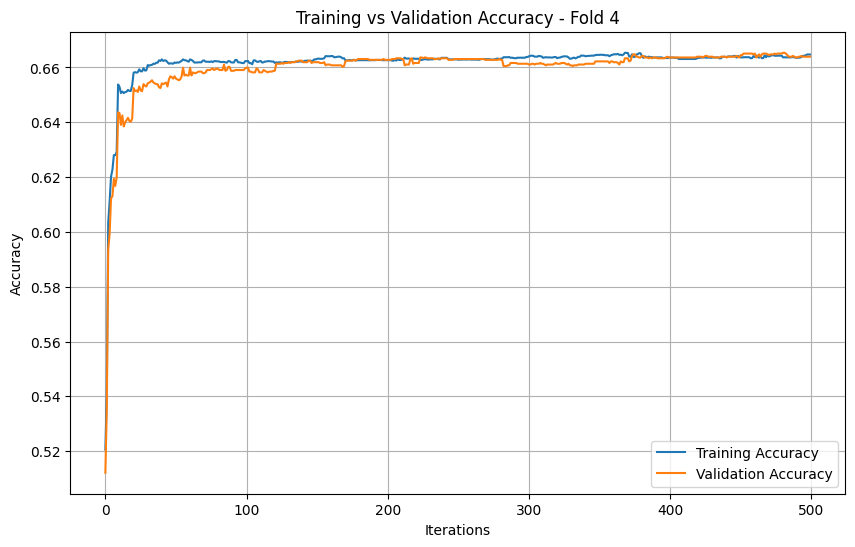

Fold 4 Validation Accuracy: 0.6639

Training fold 5/5
[0]	train-logloss:0.69085	train-error:0.48596	train-auc:0.60136	eval-logloss:0.68919	eval-error:0.46156	eval-auc:0.59734
[100]	train-logloss:0.61820	train-error:0.33643	train-auc:0.71900	eval-logloss:0.62081	eval-error:0.33981	eval-auc:0.71249
[200]	train-logloss:0.61364	train-error:0.33307	train-auc:0.72299	eval-logloss:0.61833	eval-error:0.34124	eval-auc:0.71432
[300]	train-logloss:0.61119	train-error:0.33329	train-auc:0.72551	eval-logloss:0.61738	eval-error:0.34296	eval-auc:0.71481
[400]	train-logloss:0.60931	train-error:0.33350	train-auc:0.72766	eval-logloss:0.61680	eval-error:0.34381	eval-auc:0.71570
[499]	train-logloss:0.60786	train-error:0.33150	train-auc:0.72934	eval-logloss:0.61643	eval-error:0.34210	eval-auc:0.71629


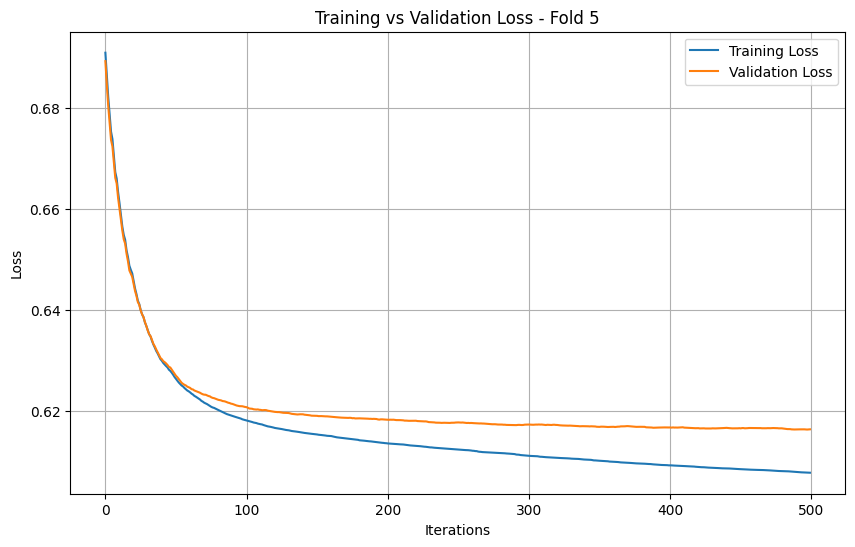

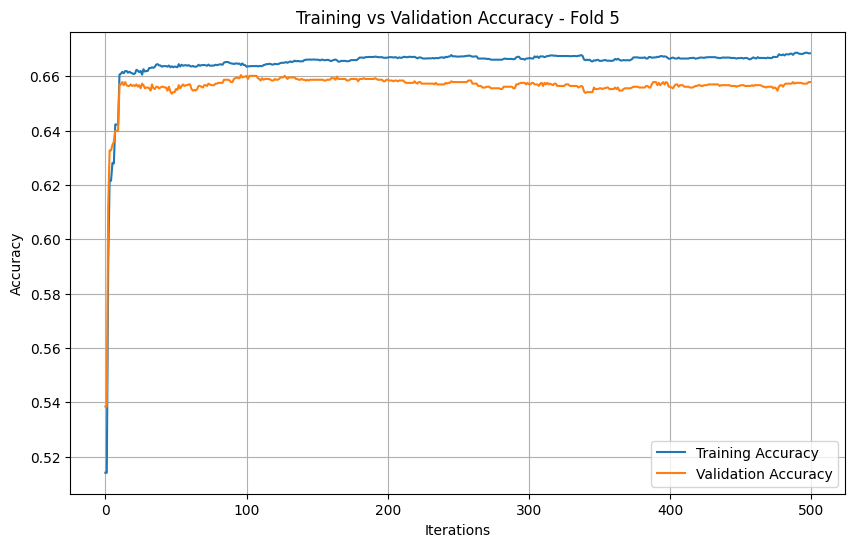

Fold 5 Validation Accuracy: 0.6579

Cross-validation Results:
Mean Accuracy: 0.6595 (+/- 0.0061)


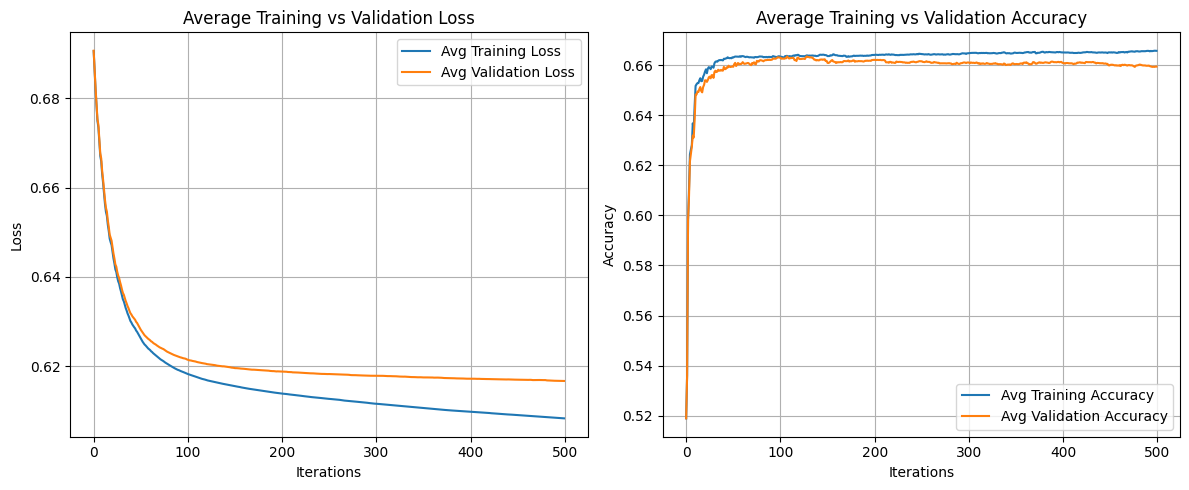


Training final model on all data...

Feature Importance Scores:
priors_count: 33.9
age: 18.3
sex_Female: 13.5
sex_Male: 13.1
race_African-American: 11.1
juv_other_count: 8.9
race_Hispanic: 6.1
juv_misd_count: 5.3
race_Other: 4.3
juv_fel_count: 3.9
race_Caucasian: 3.6
race_Native American: 2.8
race_Asian: 2.3


In [ ]:
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.calibration import CalibratedClassifierCV
import matplotlib.pyplot as plt
from xgboost import plot_importance
from xgboost.callback import TrainingCallback
import json
from graphviz import Digraph
from IPython.display import display

# Load and preprocess data
print("\nLoading and preprocessing data...")
data = pd.read_csv('cox-violent-parsed_filt.csv')

# Remove cases where is_recid is -1 (unknown/pending)
data = data[data['is_recid'] != -1].copy()

# Select specific features
X = data[["sex", 'age', 'race', 'juv_fel_count', 'juv_misd_count', 'juv_other_count',
          'priors_count', 'c_charge_degree']]
y = data['is_recid']

# Store original value ranges for denormalization
value_ranges = {}
for col in ['age', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count']:
    value_ranges[col] = {
        'min': float(X[col].min()),
        'max': float(X[col].max())
    }

# Save value ranges for visualization
with open('value_ranges.json', 'w') as f:
    json.dump(value_ranges, f)

# Fill missing values
X['c_charge_degree'] = X['c_charge_degree'].fillna('Unknown')

def categorize_charge_degree(x):
    if pd.isna(x) or x == 'Unknown':
        return 'Other'
    if str(x).startswith('F'):
        return 'Felony'
    if str(x).startswith('M'):
        return 'Misdemeanor'
    return 'Other'

X['c_charge_degree'] = X['c_charge_degree'].apply(categorize_charge_degree)

# Define categorical and numerical features
categorical_features = ['sex', 'race', 'c_charge_degree']
numerical_features = ['age', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count']

# One-hot encode categorical features
X_encoded = pd.get_dummies(X, columns=categorical_features)

# Clean up feature names
X_encoded.columns = [col.replace('[', '_').replace(']', '_').replace('<', '_').replace('>', '_')
                    for col in X_encoded.columns]

# Normalize numerical features
for col in numerical_features:
    if col in X_encoded.columns:
        min_val = X_encoded[col].min()
        max_val = X_encoded[col].max()
        if max_val > min_val:
            X_encoded[col] = (X_encoded[col] - min_val) / (max_val - min_val)

# Model parameters
params = {
    'objective': 'binary:logistic',
    'eval_metric': ['logloss', 'error', 'auc'],
    'eta': 0.05,
    'max_depth': 2,
    'min_child_weight': 2,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'scale_pos_weight': 1,
    'base_score': np.mean(y),
    'tree_method': 'hist'
}

# Initialize 5-fold cross validation
n_folds = 5
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
fold_scores = []

# Lists to store metrics for each fold
all_train_losses = []
all_val_losses = []
all_train_accuracies = []
all_val_accuracies = []

class MetricHistory(TrainingCallback):
    def __init__(self):
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []

    def after_iteration(self, model, epoch, evals_log):
        train_metrics = evals_log.get('train', {})
        eval_metrics = evals_log.get('eval', {})

        if 'logloss' in train_metrics:
            self.train_losses.append(train_metrics['logloss'][-1])
            self.val_losses.append(eval_metrics['logloss'][-1])

        if 'error' in train_metrics:
            self.train_accuracies.append(1 - train_metrics['error'][-1])
            self.val_accuracies.append(1 - eval_metrics['error'][-1])

        return False

def plot_training_metrics(train_metric, val_metric, metric_name, fold):
    plt.figure(figsize=(10, 6))
    plt.plot(train_metric, label=f'Training {metric_name}')
    plt.plot(val_metric, label=f'Validation {metric_name}')
    plt.xlabel('Iterations')
    plt.ylabel(metric_name)
    plt.title(f'Training vs Validation {metric_name} - Fold {fold+1}')
    plt.legend()
    plt.grid(True)
    plt.show()

print("\nStarting 5-fold cross-validation...")

for fold, (train_idx, val_idx) in enumerate(kf.split(X_encoded)):
    print(f"\nTraining fold {fold + 1}/{n_folds}")

    X_train, X_val = X_encoded.iloc[train_idx], X_encoded.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # Create DMatrix objects
    dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=X_encoded.columns.tolist())
    dval = xgb.DMatrix(X_val, label=y_val, feature_names=X_encoded.columns.tolist())
    evallist = [(dtrain, 'train'), (dval, 'eval')]

    # Initialize metric history
    metric_callback = MetricHistory()

    # Train the model
    model = xgb.train(
        params,
        dtrain,
        num_boost_round=500,
        early_stopping_rounds=50,
        evals=evallist,
        verbose_eval=100,
        callbacks=[metric_callback]
    )

    # Store metrics
    all_train_losses.append(metric_callback.train_losses)
    all_val_losses.append(metric_callback.val_losses)
    all_train_accuracies.append(metric_callback.train_accuracies)
    all_val_accuracies.append(metric_callback.val_accuracies)

    # Plot metrics for this fold
    plot_training_metrics(metric_callback.train_losses, metric_callback.val_losses, 'Loss', fold)
    plot_training_metrics(metric_callback.train_accuracies, metric_callback.val_accuracies, 'Accuracy', fold)

    # Calculate and store fold score
    val_pred = model.predict(dval)
    fold_accuracy = ((val_pred > 0.5) == y_val).mean()
    fold_scores.append(fold_accuracy)
    print(f"Fold {fold + 1} Validation Accuracy: {fold_accuracy:.4f}")

# Print overall cross-validation results
print("\nCross-validation Results:")
print(f"Mean Accuracy: {np.mean(fold_scores):.4f} (+/- {np.std(fold_scores):.4f})")

# Plot average metrics across all folds
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
mean_train_loss = np.mean(all_train_losses, axis=0)
mean_val_loss = np.mean(all_val_losses, axis=0)
plt.plot(mean_train_loss, label='Avg Training Loss')
plt.plot(mean_val_loss, label='Avg Validation Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Average Training vs Validation Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
mean_train_acc = np.mean(all_train_accuracies, axis=0)
mean_val_acc = np.mean(all_val_accuracies, axis=0)
plt.plot(mean_train_acc, label='Avg Training Accuracy')
plt.plot(mean_val_acc, label='Avg Validation Accuracy')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('Average Training vs Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Train final model on all data
print("\nTraining final model on all data...")
dtrain_full = xgb.DMatrix(X_encoded, label=y, feature_names=X_encoded.columns.tolist())
final_model = xgb.train(params, dtrain_full, num_boost_round=model.best_iteration)

# Save the final model
final_model.save_model('xgboost_model.json')

# Get feature importance scores
importance_type = 'gain'
scores = final_model.get_score(importance_type=importance_type)
feature_importance = pd.DataFrame({
    'feature': list(scores.keys()),
    'importance': list(scores.values())
}).sort_values('importance', ascending=False)

print("\nFeature Importance Scores:")
for idx, row in feature_importance.iterrows():
    print(f"{row['feature']}: {row['importance']:.1f}")

# Save feature importance to CSV
feature_importance.to_csv('feature_importance.csv', index=False)



##One-tree Test


Loading and preprocessing data...

Starting 5-fold cross-validation with single trees...

Training fold 1/5
[0]	train-logloss:0.63290	train-error:0.35239	train-auc:0.69168	eval-logloss:0.63068	eval-error:0.34171	eval-auc:0.69652


/tmp/ipython-input-13-3343689182.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['c_charge_degree'] = X['c_charge_degree'].fillna('Unknown')
/tmp/ipython-input-13-3343689182.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['c_charge_degree'] = X['c_charge_degree'].apply(categorize_charge_degree)


Fold 1 Metrics:
  Training Loss: 0.6329
  Validation Loss: 0.6307
  Training Accuracy: 0.6476
  Validation Accuracy: 0.6583

Training fold 2/5
[0]	train-logloss:0.63045	train-error:0.34757	train-auc:0.69573	eval-logloss:0.63907	eval-error:0.35353	eval-auc:0.68006
Fold 2 Metrics:
  Training Loss: 0.6304
  Validation Loss: 0.6391
  Training Accuracy: 0.6524
  Validation Accuracy: 0.6465

Training fold 3/5
[0]	train-logloss:0.63175	train-error:0.34600	train-auc:0.69316	eval-logloss:0.63062	eval-error:0.34610	eval-auc:0.69659
Fold 3 Metrics:
  Training Loss: 0.6318
  Validation Loss: 0.6306
  Training Accuracy: 0.6540
  Validation Accuracy: 0.6539

Training fold 4/5
[0]	train-logloss:0.63053	train-error:0.34479	train-auc:0.69537	eval-logloss:0.63528	eval-error:0.35096	eval-auc:0.68848
Fold 4 Metrics:
  Training Loss: 0.6305
  Validation Loss: 0.6353
  Training Accuracy: 0.6552
  Validation Accuracy: 0.6490

Training fold 5/5
[0]	train-logloss:0.63211	train-error:0.34436	train-auc:0.69179	e

/tmp/ipython-input-13-3343689182.py:173: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([fold_train_losses, fold_val_losses], labels=['Training', 'Validation'])
/tmp/ipython-input-13-3343689182.py:180: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([fold_train_accuracies, fold_val_accuracies], labels=['Training', 'Validation'])


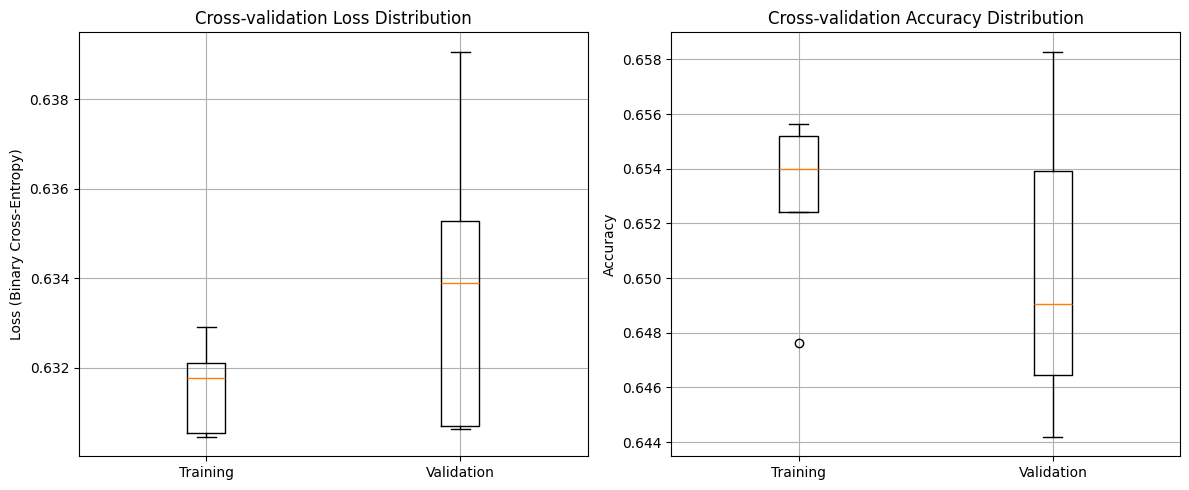


Training final single tree model on all data...

Feature Importance Scores:
priors_count: 407.9
age: 255.7
sex_Female: 72.2


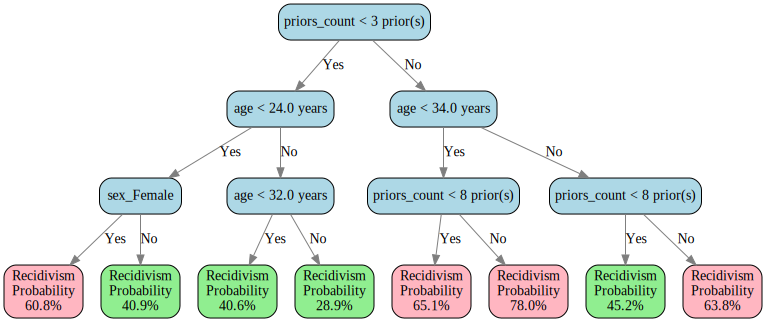

In [13]:
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.calibration import CalibratedClassifierCV
import matplotlib.pyplot as plt
from xgboost import plot_importance
from xgboost.callback import TrainingCallback
import json
from graphviz import Digraph
from IPython.display import display

# Load and preprocess data
print("\nLoading and preprocessing data...")
data = pd.read_csv('cox-violent-parsed_filt.csv')

# Remove cases where is_recid is -1 (unknown/pending)
data = data[data['is_recid'] != -1].copy()

# Select specific features
X = data[["sex", 'age', 'race', 'juv_fel_count', 'juv_misd_count', 'juv_other_count',
          'priors_count', 'c_charge_degree']]
y = data['is_recid']

# Store original value ranges for denormalization
value_ranges = {}
for col in ['age', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count']:
    value_ranges[col] = {
        'min': float(X[col].min()),
        'max': float(X[col].max())
    }

# Save value ranges for visualization
with open('value_ranges.json', 'w') as f:
    json.dump(value_ranges, f)

# Fill missing values
X['c_charge_degree'] = X['c_charge_degree'].fillna('Unknown')

def categorize_charge_degree(x):
    if pd.isna(x) or x == 'Unknown':
        return 'Other'
    if str(x).startswith('F'):
        return 'Felony'
    if str(x).startswith('M'):
        return 'Misdemeanor'
    return 'Other'

X['c_charge_degree'] = X['c_charge_degree'].apply(categorize_charge_degree)

# Define categorical and numerical features
categorical_features = ['sex', 'race', 'c_charge_degree']
numerical_features = ['age', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count']

# One-hot encode categorical features
X_encoded = pd.get_dummies(X, columns=categorical_features)

# Clean up feature names
X_encoded.columns = [col.replace('[', '_').replace(']', '_').replace('<', '_').replace('>', '_')
                    for col in X_encoded.columns]

# Normalize numerical features
for col in numerical_features:
    if col in X_encoded.columns:
        min_val = X_encoded[col].min()
        max_val = X_encoded[col].max()
        if max_val > min_val:
            X_encoded[col] = (X_encoded[col] - min_val) / (max_val - min_val)

# Model parameters for a single tree
params = {
    'objective': 'binary:logistic',
    'eval_metric': ['logloss', 'error', 'auc'],
    'eta': 1.0,  # Learning rate of 1.0 for single tree
    'max_depth': 3,
    'min_child_weight': 2,
    'subsample': 1.0,  # Use all data
    'colsample_bytree': 1.0,  # Use all features
    'scale_pos_weight': 1,
    'base_score': np.mean(y),
    'tree_method': 'hist'
}

# Initialize 5-fold cross validation
n_folds = 5
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

# Lists to store metrics for each fold
fold_train_losses = []
fold_val_losses = []
fold_train_accuracies = []
fold_val_accuracies = []
all_predictions = []  # Store all validation predictions
all_true_values = []  # Store all validation true values

print("\nStarting 5-fold cross-validation with single trees...")

for fold, (train_idx, val_idx) in enumerate(kf.split(X_encoded)):
    print(f"\nTraining fold {fold + 1}/{n_folds}")

    X_train, X_val = X_encoded.iloc[train_idx], X_encoded.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # Create DMatrix objects
    dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=X_encoded.columns.tolist())
    dval = xgb.DMatrix(X_val, label=y_val, feature_names=X_encoded.columns.tolist())
    evallist = [(dtrain, 'train'), (dval, 'eval')]

    # Train a single tree
    model = xgb.train(
        params,
        dtrain,
        num_boost_round=1,  # Force only one tree
        evals=evallist,
        verbose_eval=True
    )

    # Get predictions
    train_pred = model.predict(dtrain)
    val_pred = model.predict(dval)

    # Calculate metrics
    train_loss = -np.mean(y_train * np.log(train_pred + 1e-10) + (1 - y_train) * np.log(1 - train_pred + 1e-10))
    val_loss = -np.mean(y_val * np.log(val_pred + 1e-10) + (1 - y_val) * np.log(1 - val_pred + 1e-10))

    train_acc = ((train_pred > 0.5) == y_train).mean()
    val_acc = ((val_pred > 0.5) == y_val).mean()

    # Store metrics
    fold_train_losses.append(train_loss)
    fold_val_losses.append(val_loss)
    fold_train_accuracies.append(train_acc)
    fold_val_accuracies.append(val_acc)

    # Store predictions and true values for overall accuracy
    all_predictions.extend((val_pred > 0.5).astype(int))
    all_true_values.extend(y_val)

    print(f"Fold {fold + 1} Metrics:")
    print(f"  Training Loss: {train_loss:.4f}")
    print(f"  Validation Loss: {val_loss:.4f}")
    print(f"  Training Accuracy: {train_acc:.4f}")
    print(f"  Validation Accuracy: {val_acc:.4f}")

# Calculate overall accuracy across all folds
overall_accuracy = np.mean(np.array(all_predictions) == np.array(all_true_values))

# Calculate mean and standard deviation of metrics
mean_train_loss = np.mean(fold_train_losses)
std_train_loss = np.std(fold_train_losses)
mean_val_loss = np.mean(fold_val_losses)
std_val_loss = np.std(fold_val_losses)

mean_train_acc = np.mean(fold_train_accuracies)
std_train_acc = np.std(fold_train_accuracies)
mean_val_acc = np.mean(fold_val_accuracies)
std_val_acc = np.std(fold_val_accuracies)

# Print overall results
print("\nOverall Cross-validation Results:")
print(f"Overall Accuracy: {overall_accuracy:.4f}")
print(f"Training Loss: {mean_train_loss:.4f} (±{std_train_loss:.4f})")
print(f"Validation Loss: {mean_val_loss:.4f} (±{std_val_loss:.4f})")
print(f"Training Accuracy: {mean_train_acc:.4f} (±{std_train_acc:.4f})")
print(f"Validation Accuracy: {mean_val_acc:.4f} (±{std_val_acc:.4f})")

# Plot cross-validation results
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.boxplot([fold_train_losses, fold_val_losses], labels=['Training', 'Validation'])
plt.ylabel('Loss (Binary Cross-Entropy)')
plt.title('Cross-validation Loss Distribution')
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.boxplot([fold_train_accuracies, fold_val_accuracies], labels=['Training', 'Validation'])
plt.ylabel('Accuracy')
plt.title('Cross-validation Accuracy Distribution')
plt.grid(True)

plt.tight_layout()
plt.show()

# Train final model on all data
print("\nTraining final single tree model on all data...")
dtrain_full = xgb.DMatrix(X_encoded, label=y, feature_names=X_encoded.columns.tolist())
final_model = xgb.train(params, dtrain_full, num_boost_round=1)

# Save the final model
final_model.save_model('single_tree_model.json')

# Get feature importance scores
importance_type = 'gain'
scores = final_model.get_score(importance_type=importance_type)
feature_importance = pd.DataFrame({
    'feature': list(scores.keys()),
    'importance': list(scores.values())
}).sort_values('importance', ascending=False)

print("\nFeature Importance Scores:")
for idx, row in feature_importance.iterrows():
    print(f"{row['feature']}: {row['importance']:.1f}")

# Save feature importance to CSV
feature_importance.to_csv('feature_importance.csv', index=False)

# Create detailed tree visualization
from graphviz import Digraph
import re
import numpy as np

# Get the tree dump in text format
tree = model.get_dump(dump_format='text')[0]

# Create a new directed graph
dot = Digraph(comment='Decision Tree')
dot.attr(rankdir='TB')  # Top to bottom layout

# Parse the tree dump and create nodes
node_pattern = re.compile(r'(\d+):\[([^\]]+)\] yes=(\d+),no=(\d+).*')
leaf_pattern = re.compile(r'(\d+):leaf=([-\d\.]+)')

def format_node_label(text):
    """Format the node label with actual values"""
    for feature in value_ranges.keys():
        if feature in text:
            match = re.search(rf'{feature}<([\d\.]+)', text)
            if match:
                value = float(match.group(1))
                actual_value = value_ranges[feature]['min'] + float(value) * (value_ranges[feature]['max'] - value_ranges[feature]['min'])
                if feature == 'age':
                    return f'{feature} < {actual_value:.1f} years'
                elif feature.endswith('count'):
                    return f'{feature} < {round(actual_value)} prior(s)'
                else:
                    return f'{feature} < {actual_value:.1f}'
    return text

# Set graph style
dot.attr('node', shape='box', style='rounded,filled', fillcolor='lightblue')
dot.attr('edge', color='gray50')
dot.attr(bgcolor='white')

# Process each line of the tree dump
for line in tree.split('\n'):
    # Skip empty lines
    if not line.strip():
        continue

    # Check if it's a leaf node
    leaf_match = leaf_pattern.match(line.strip())
    if leaf_match:
        node_id, leaf_value = leaf_match.groups()
        prob_value = 1 / (1 + np.exp(-float(leaf_value)))
        # Color leaf nodes based on prediction
        color = 'lightpink' if prob_value >= 0.5 else 'lightgreen'
        dot.node(str(node_id), f'Recidivism\nProbability\n{prob_value:.1%}',
                fillcolor=color)
        continue

    # Process split node
    node_match = node_pattern.match(line.strip())
    if node_match:
        node_id, condition, yes_id, no_id = node_match.groups()
        # Format the condition
        formatted_condition = format_node_label(condition)
        dot.node(str(node_id), formatted_condition)
        # Add edges with labels
        dot.edge(str(node_id), str(yes_id), 'Yes')
        dot.edge(str(node_id), str(no_id), 'No')

# Set graph attributes for better visualization
dot.attr(size='20,40')  # Swapped dimensions for vertical layout
dot.attr(fontsize='14')

# Display the graph in the notebook
from IPython.display import display
display(dot)